In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.utils.class_weight import compute_class_weight
import re
import os
import random

# --- CONFIGURAZIONE GLOBALE ---
SEQ_LEN = 30       # Fixed sequence length
BATCH_SIZE = 64
EPOCHS = 10
LR = 1e-3
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Define the path
save_path = 'tennis_shot_forecasting.pth'

# Seed everything to avoid randomness
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    print(f"Random seed set to {seed}")

# Call it immediately
seed_everything(42)

# --- 1. DATASET (Restored & Fixed) ---
class MCPTennisDataset(Dataset):
    def __init__(self, points_paths_list, matches_path, atp_path, wta_path, max_seq_len=30):
        self.max_seq_len = max_seq_len
        print("Initializing Dataset with CORRECTED Parsing Logic...")
        
        # 1. Load Player Data (Height & Hand)
        self.player_vocab = {'<pad>': 0, '<unk>': 1}
        self.player_stats = {} # {name: {'hand': 'R', 'height': 185}}
        self._build_player_stats(atp_path, wta_path)
        
        # 2. Load Matches
        try:
            self.matches_df = pd.read_csv(matches_path, encoding='ISO-8859-1', engine='python', on_bad_lines='skip')
        except:
            self.matches_df = pd.read_csv(matches_path, encoding='ISO-8859-1', quoting=3)
        self.match_meta = self._process_match_metadata(self.matches_df)
        
        # 3. Load Points
        dfs = []
        for p_path in points_paths_list:
            if not os.path.exists(p_path): continue
            try:
                d = pd.read_csv(p_path, encoding='ISO-8859-1', engine='python', on_bad_lines='skip')
                dfs.append(d)
            except:
                d = pd.read_csv(p_path, encoding='ISO-8859-1', quoting=3)
                dfs.append(d)
        
        if dfs:
            self.df = pd.concat(dfs, ignore_index=True)
            # Sort by Match and Point to track flow
            self.df['Pt'] = pd.to_numeric(self.df['Pt'], errors='coerce').fillna(0)
            self.df = self.df.sort_values(by=['match_id', 'Pt'])
        else:
            self.df = pd.DataFrame()

        # 4. Vocabularies based on Documentation
        self.surface_vocab = {'<pad>': 0, 'Hard': 1, 'Clay': 2, 'Grass': 3, 'Carpet': 4}
        self.hand_vocab = {'<pad>': 0, 'R': 1, 'L': 2}
        
        # The Unified Token Vocabulary
        # We will build this dynamically as we parse to ensure we capture all valid combinations
        # e.g. "Serve_6", "f_1_7", "b_2"
        self.unified_vocab = {'<pad>': 0, '<unk>': 1}
        self.inv_unified_vocab = {0: '<pad>', 1: '<unk>'}
        
        # Data Containers
        self.data_x_seq = []   # Sequence of Unified Token IDs
        self.data_context = [] # Fixed context (Players, Surface, Score)
        self.data_x_s_id = []  # Server ID
        self.data_x_r_id = []  # Receiver ID
        self.data_y_type = [] # Target List
        self.sample_match_ids = []
        
        self.process_data()

    def _build_player_stats(self, atp_path, wta_path):
        for path in [atp_path, wta_path]:
            if not os.path.exists(path): continue
            try:
                df = pd.read_csv(path, encoding='utf-8', on_bad_lines='skip')
                df['full_name'] = df['name_first'].str.strip() + " " + df['name_last'].str.strip()
                
                for _, row in df.iterrows():
                    name = row['full_name']
                    if name not in self.player_vocab:
                        self.player_vocab[name] = len(self.player_vocab)
                    
                    h = row.get('height')
                    hand = row.get('hand', 'R')
                    
                    height_val = 185 # Default
                    if pd.notna(h) and str(h).isdigit():
                        height_val = float(h)
                        
                    self.player_stats[name] = {'hand': hand, 'height': height_val}
            except: pass

    def _process_match_metadata(self, df):
        meta = {}
        for _, row in df.iterrows():
            m_id = row['match_id']
            # Surface
            raw_surf = str(row.get('Surface', 'Hard'))
            if 'Hard' in raw_surf: surf = 'Hard'
            elif 'Clay' in raw_surf: surf = 'Clay'
            elif 'Grass' in raw_surf: surf = 'Grass'
            else: surf = 'Hard'
            
            p1 = str(row.get('Player 1', ''))
            p2 = str(row.get('Player 2', ''))
            
            # Lookup Hand/Height from our loaded stats
            stats1 = self.player_stats.get(p1, {'hand': 'R', 'height': 185})
            stats2 = self.player_stats.get(p2, {'hand': 'R', 'height': 185})
            
            meta[m_id] = {
                'surface': surf, 
                'p1_name': p1, 'p2_name': p2, 
                'p1_hand': stats1['hand'], 'p2_hand': stats2['hand'],
                'p1_h': stats1['height'], 'p2_h': stats2['height']
            }
        return meta

    def get_pressure_score(self, pts, gm1, gm2):
        # 0=Normal, 1=Tiebreak, 2=BreakPoint
        if not isinstance(pts, str) or '-' not in pts: return 0
        try:
            s_pts, r_pts = pts.split('-')
            # Check Break Point (Receiver has 40 or AD)
            if (r_pts == '40' and s_pts != '40' and s_pts != 'AD') or (r_pts == 'AD'):
                return 2
            # Check Tiebreak
            if int(gm1) == 6 and int(gm2) == 6:
                return 1
        except: pass
        return 0

    def process_data(self):
        print("Parsing Rallies into Unified Tokens...")
        
        # Regex to split shots:
        # 1. Serves: Start with 4, 5, or 6. Can have modifiers (+, -, =).
        # 2. Shots: Start with char (f, b, s, r, v, ...).
        # We split the string by looking for these boundaries.
        
        # Pattern explanation:
        # ([456][0-9+=-]*)  -> Capture Serve (starts with 4,5,6, followed by optional chars)
        # |                 -> OR
        # ([fbsrvolmzup][0-9+=-]*) -> Capture Shot (starts with type char, followed by optional chars)
        split_pattern = re.compile(r'([456][0-9+=-]*|[fbsrvolmzup][0-9+=-]*)')
        
        # Helper to extract digits from a shot string
        # e.g. "s17" -> ['1', '7']
        digit_pattern = re.compile(r'\d')
        
        prev_point_state = (0, 0) # (WinnerWasServer, RallyLen)
        last_match_id = None
        
        for _, row in self.df.iterrows():
            match_id = row['match_id']
            if match_id != last_match_id:
                prev_point_state = (0, 0)
                last_match_id = match_id
            
            rally_str = str(row['2nd']) if pd.notna(row['2nd']) else str(row['1st'])
            if pd.isna(rally_str) or rally_str == 'nan': continue

            # --- CONTEXT ---
            m_meta = self.match_meta.get(match_id, {'surface': 'Hard', 'p1_name':'?', 'p2_name':'?'})
            
            svr = row['Svr'] if 'Svr' in row else 1
            if svr == 2:
                s_name, r_name = m_meta['p2_name'], m_meta['p1_name']
                s_h, r_h = m_meta['p2_h'], m_meta['p1_h']
                s_hand, r_hand = m_meta['p2_hand'], m_meta['p1_hand']
            else:
                s_name, r_name = m_meta['p1_name'], m_meta['p2_name']
                s_h, r_h = m_meta['p1_h'], m_meta['p2_h']
                s_hand, r_hand = m_meta['p1_hand'], m_meta['p2_hand']

            s_id = self.player_vocab.get(s_name, 1)
            r_id = self.player_vocab.get(r_name, 1)
            
            # Context Features
            surf_idx = self.surface_vocab.get(m_meta['surface'], 1)
            sh_idx = self.hand_vocab.get(s_hand, 1)
            rh_idx = self.hand_vocab.get(r_hand, 1)
            sh_norm = (s_h - 180) / 10.0
            rh_norm = (r_h - 180) / 10.0
            pressure = self.get_pressure_score(str(row.get('Pts','')), row.get('Gm1',0), row.get('Gm2',0))
            prev_win, prev_len = prev_point_state
            is_2nd = 1 if pd.notna(row['2nd']) else 0
            
            context_vec = [surf_idx, sh_idx, rh_idx, sh_norm, rh_norm, pressure, prev_win, prev_len, is_2nd, 0]

            # --- RALLY PARSING ---
            r_clean = re.sub(r'[@#n*!+;]', '', rally_str).lstrip('c')
            if not r_clean: continue
            
            # Find all shots
            raw_shots = split_pattern.findall(r_clean)
            if not raw_shots: continue
            
            unified_tokens = []
            
            for i, shot_str in enumerate(raw_shots):
                # 1. PARSE SERVE (First shot, starts with digit)
                if shot_str[0].isdigit():
                    # Format: "6", "5", "4+"
                    direction = shot_str[0] # 4, 5, or 6
                    token = f"Serve_{direction}"
                else:
                    # 2. PARSE SHOT (Starts with char)
                    # Format: "f1", "s17", "b2"
                    typ = shot_str[0] # f, b, s, ...
                    
                    # Extract digits
                    digits = digit_pattern.findall(shot_str)
                    
                    direction = digits[0] if len(digits) > 0 else '0' # 1, 2, 3
                    depth = digits[1] if len(digits) > 1 else '0'     # 7, 8, 9
                    
                    token = f"{typ}_{direction}_{depth}"
                
                # Add to vocab if new
                if token not in self.unified_vocab:
                    self.unified_vocab[token] = len(self.unified_vocab)
                    self.inv_unified_vocab[self.unified_vocab[token]] = token
                
                unified_tokens.append(self.unified_vocab[token])
            
            # Create Sequence
            if len(unified_tokens) >= 2:
                # Update Flow State
                curr_winner = row.get('PtWinner', 0)
                try: curr_winner = int(curr_winner)
                except: curr_winner = 0
                prev_point_state = (1 if curr_winner == svr else 0, len(unified_tokens))
                
                # Input: [Serve, Shot1, Shot2...]
                # Target: [Shot1, Shot2, Shot3...]
                
                seq_x = unified_tokens[:-1]
                seq_y = unified_tokens[1:]
                
                L = min(len(seq_x), self.max_seq_len)
                pad = [0] * (self.max_seq_len - L)
                
                self.data_x_seq.append(pad + seq_x[:L])
                self.data_context.append(context_vec)
                self.data_x_s_id.append(s_id)
                self.data_x_r_id.append(r_id)
                
                # Target is just the Unified ID
                self.data_y_type.append(pad + seq_y[:L]) # Reusing this list name for Y
                self.sample_match_ids.append(match_id)

        print(f"Dataset Built. Unique Unified Shots Found: {len(self.unified_vocab)}")
        
        self.x_seq_tensor = torch.tensor(self.data_x_seq, dtype=torch.long)
        self.context_tensor = torch.tensor(self.data_context, dtype=torch.float32)
        self.x_s_id_tensor = torch.tensor(self.data_x_s_id, dtype=torch.long)
        self.x_r_id_tensor = torch.tensor(self.data_x_r_id, dtype=torch.long)
        self.y_target_tensor = torch.tensor(self.data_y_type, dtype=torch.long)
        
        del self.data_x_seq, self.data_y_type

    def __len__(self): return len(self.sample_match_ids)
    def __getitem__(self, idx):
        return {
            'x_seq': self.x_seq_tensor[idx],
            'context': self.context_tensor[idx],
            'x_s_id': self.x_s_id_tensor[idx],
            'x_r_id': self.x_r_id_tensor[idx],
            'y_target': self.y_target_tensor[idx]
        }

Random seed set to 42


In [3]:
class MultiTaskCristianGPT(nn.Module):
    def __init__(self, dir_vocab_size, depth_vocab_size, type_vocab_size, num_players, context_dim=6, embed_dim=64, n_head=4, n_cycles=3, seq_len=30, zone_vocab_size=None):        
        super().__init__()
        self.n_cycles = n_cycles
        
        player_dim = 64
        
        # 1. Embeddings
        inp_vocab = zone_vocab_size if zone_vocab_size else dir_vocab_size
        self.zone_emb = nn.Embedding(inp_vocab, embed_dim)
        self.type_emb = nn.Embedding(type_vocab_size, embed_dim)
        self.player_emb = nn.Embedding(num_players, player_dim) # Player Embedding
        
        # And update the context fusion to match:
        self.context_fusion = nn.Sequential(
            nn.Linear(context_dim + (player_dim * 2), embed_dim), 
            nn.ReLU(),
            nn.Linear(embed_dim, embed_dim)
        )
        
        # 3. Dimensions
        # Input = Zone(embed_dim) + Type(embed_dim) + Context(embed_dim) = embed_dim * 3
        self.input_dim = embed_dim * 3 
        
        # 4. Position Embedding (FIXED SIZE)
        # We initialize it with input_dim so it matches x immediately.
        self.pos_emb = nn.Parameter(torch.randn(1, seq_len, self.input_dim))
        
        # 5. Transformer
        self.shared_block = nn.TransformerEncoderLayer(
            d_model=self.input_dim, nhead=n_head, dim_feedforward=embed_dim * 8,
            batch_first=True, norm_first=True, dropout=0.1
        )
        
        self.norm_f = nn.LayerNorm(self.input_dim)
        
        # --- THE THREE HEADS ---
        # Head 1: Where is it going? (Left/Right/Center)
        self.head_dir = nn.Linear(self.input_dim, dir_vocab_size)
        
        # Head 2: How deep is it? (Short/Deep)
        self.head_depth = nn.Linear(self.input_dim, depth_vocab_size)
        
        # Head 3: What shot is it? (Forehand/Backhand/Volley)
        self.head_type = nn.Linear(self.input_dim, type_vocab_size)

    def generate_causal_mask(self, sz):
        """Generates a mask to prevent looking at future tokens."""
        # Returns a matrix of shape (sz, sz) with -inf in the upper triangle
        return torch.triu(torch.full((sz, sz), float('-inf')), diagonal=1).to(DEVICE)
    
    def forward(self, x_z, x_t, x_c, x_s, x_r):
        # Embeddings
        z = self.zone_emb(x_z) 
        t = self.type_emb(x_t) 
        s_emb = self.player_emb(x_s)
        r_emb = self.player_emb(x_r)
        
        # Fuse Context + Players
        c_combined = torch.cat([x_c, s_emb, r_emb], dim=1) 
        c = self.context_fusion(c_combined) 
        c = c.unsqueeze(1).expand(-1, z.size(1), -1)
        
        # Main Sequence
        x = torch.cat([z, t, c], dim=-1) 
        x = x + self.pos_emb[:, :x.size(1), :]
        
        # Causal Mask (To prevent leakage)
        causal_mask = self.generate_causal_mask(x.size(1))
        
        memory = x.clone()
        for _ in range(self.n_cycles):
            memory = self.shared_block(memory, src_mask=causal_mask)
            
        # Split into 3 outputs
        logits_dir = self.head_dir(self.norm_f(memory))
        logits_depth = self.head_depth(self.norm_f(memory))
        logits_type = self.head_type(self.norm_f(memory))
        
        return logits_dir, logits_depth, logits_type

In [2]:
from torch.optim.lr_scheduler import OneCycleLR

base_path = '/kaggle/input/atp-points/'

# List all point files to merge
point_files = [
    base_path + 'charting-m-points-2020s.csv',
    base_path + 'charting-m-points-2010s.csv',
    base_path + 'charting-m-points-to-2009.csv'
]

# New Matches File
matches_path = '/kaggle/input/atp-matches-updated/charting-m-matches-updated.csv'

atp_path = '/kaggle/input/atp-players/atp_players.csv'
wta_path = '/kaggle/input/wta-players/wta_players.csv'

# Standard Focal Loss (Reused for all heads)
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.reduction = reduction
        self.alpha = alpha
        
    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', ignore_index=0)
        pt = torch.exp(-ce_loss) 
        focal_loss = (1 - pt) ** self.gamma * ce_loss
        
        if self.alpha is not None:
            if self.alpha.device != inputs.device:
                self.alpha = self.alpha.to(inputs.device)
            at = self.alpha.gather(0, targets.view(-1))
            focal_loss = focal_loss * at
            
        if self.reduction == 'mean':
            mask = targets != 0
            if mask.sum() > 0:
                return focal_loss[mask].mean()
            else:
                return torch.tensor(0.0, device=inputs.device, requires_grad=True)
        else:
            return focal_loss

# Helper function to calculate weights for a specific target list
def get_balanced_weights(target_tensor, num_classes, power=0.3):
    # 1. Flatten the big tensor directly (Very fast)
    flat = target_tensor.view(-1).numpy()
    
    # 2. Filter padding (0)
    valid = flat[flat != 0]
    
    # 3. Compute Weights
    unique = np.unique(valid)
    raw_weights = compute_class_weight(class_weight='balanced', classes=unique, y=valid)
    smoothed_weights = raw_weights ** power
    
    weights_list = [0.0] # Index 0 is padding
    for i in range(1, num_classes + 1):
        if i in unique:
            idx = np.where(unique == i)[0][0]
            weights_list.append(float(smoothed_weights[idx]))
        else:
            weights_list.append(1.0)
            
    # Cap weights
    MAX_WEIGHT = 15.0
    weights_list = [min(w, MAX_WEIGHT) for w in weights_list]
    return torch.tensor(weights_list, dtype=torch.float32).to(DEVICE)

# Check if files exist
if os.path.exists(matches_path):
    # 1. Initialize Dataset (Using the NEW Multi-Task process_data)
    dataset = MCPTennisDataset(
        points_paths_list=point_files, 
        matches_path=matches_path, 
        atp_path=atp_path, 
        wta_path=wta_path, 
        max_seq_len=SEQ_LEN
    )
    
    # --- 1. CALCULATE AUTOMATIC WEIGHTS (FOR 3 HEADS) ---
    print("\nCalculating Balanced Weights for Multi-Task Heads...")
    
    # Direction Weights (e.g. 1, 2, 3...)
    w_dir = get_balanced_weights(dataset.y_dir_tensor, len(dataset.dir_vocab))
    print(f"Direction Weights: {w_dir}")

    # Depth Weights (e.g. 7, 8, 9 mapped to 1, 2, 3)
    w_dep = get_balanced_weights(dataset.y_depth_tensor, len(dataset.depth_vocab))
    print(f"Depth Weights: {w_dep}")

    # Type Weights (e.g. f, b, s...)
    w_typ = get_balanced_weights(dataset.y_type_tensor, len(dataset.shot_vocab))
    print(f"Shot Type Weights: {w_typ}")
        
    # --- SPLIT BY MATCH ---
    # 3. SPLIT (80% Train, 10% Val, 10% Test)
    print("\nSplitting Data (80/10/10)...")
    all_matches = sorted(list(set(dataset.sample_match_ids))) #Sort for consistency
    
    # First Split: 80% Train, 20% Temp
    train_matches, temp_matches = train_test_split(all_matches, test_size=0.20, random_state=42)
    
    # Second Split: Split the 20% Temp into 50/50 (10% Val, 10% Test)
    val_matches, test_matches = train_test_split(temp_matches, test_size=0.50, random_state=42)
    
    train_set = set(train_matches)
    val_set = set(val_matches)
    test_set = set(test_matches)
    
    train_indices = [i for i, m in enumerate(dataset.sample_match_ids) if m in train_set]
    val_indices = [i for i, m in enumerate(dataset.sample_match_ids) if m in val_set]
    test_indices = [i for i, m in enumerate(dataset.sample_match_ids) if m in test_set]
    
    print(f"Train Samples: {len(train_indices)} | Val Samples: {len(val_indices)} | Test Samples: {len(test_indices)}")

    train_loader = DataLoader(Subset(dataset, train_indices), batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    val_loader = DataLoader(Subset(dataset, val_indices), batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
    test_loader = DataLoader(Subset(dataset, test_indices), batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

    seed_everything(42)
    
    # 5. Initialize Multi-Task Model
    model = MultiTaskCristianGPT(
        dir_vocab_size=len(dataset.dir_vocab),
        depth_vocab_size=len(dataset.depth_vocab),
        type_vocab_size=len(dataset.shot_vocab),
        zone_vocab_size=len(dataset.zone_vocab), # Keep this if embedding uses shared vocab, else ignore
        num_players=len(dataset.player_vocab),
        context_dim=6, 
        seq_len=SEQ_LEN,
        embed_dim=64
    ).to(DEVICE)
    
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)
    scheduler = OneCycleLR(optimizer, max_lr=2e-4, steps_per_epoch=len(train_loader), epochs=EPOCHS, pct_start=0.4, div_factor=25, final_div_factor=1000)

    # 6. Initialize 3 Loss Functions
    criterion_dir = FocalLoss(alpha=w_dir, gamma=2.0)
    criterion_depth = FocalLoss(alpha=w_dep, gamma=2.0)
    criterion_type = FocalLoss(alpha=w_typ, gamma=2.0)

    best_val_loss = float('inf')
    patience = 5
    trigger_times = 0
        
    # 7. Training Loop (Multi-Task)
    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0
        
        for batch in train_loader:
            # Inputs
            x_z = batch['x_zone'].to(DEVICE) # Input sequence (History)
            x_t = batch['x_type'].to(DEVICE)
            x_c = batch['context'].to(DEVICE)
            x_s = batch['x_s_id'].to(DEVICE)
            x_r = batch['x_r_id'].to(DEVICE)
            
            # Targets (3 Heads)
            y_d = batch['y_dir'].to(DEVICE)
            y_dp = batch['y_depth'].to(DEVICE)
            y_tp = batch['y_type'].to(DEVICE)
            
            optimizer.zero_grad()
            
            # Forward (Expect 3 outputs)
            logits_d, logits_dp, logits_tp = model(x_z, x_t, x_c, x_s, x_r)
            
            # Calculate 3 Losses
            loss_d = criterion_dir(logits_d.view(-1, len(dataset.dir_vocab)), y_d.view(-1))
            loss_dp = criterion_depth(logits_dp.view(-1, len(dataset.depth_vocab)), y_dp.view(-1))
            loss_tp = criterion_type(logits_tp.view(-1, len(dataset.shot_vocab)), y_tp.view(-1))
            
            # Weighted Sum FOR LOSS VERY IMPORTANT
            total_loss = loss_d + (0.5 * loss_dp) + (0.75 * loss_tp)
            
            total_loss.backward()
            optimizer.step()
            scheduler.step()
            train_loss += total_loss.item()
            
        # Validation
        model.eval()
        val_loss = 0
        correct_d, correct_dp, correct_tp = 0, 0, 0
        total_d, total_dp, total_tp = 0, 0, 0
        
        with torch.no_grad():
            for batch in val_loader:
                x_z = batch['x_zone'].to(DEVICE)
                x_t = batch['x_type'].to(DEVICE)
                x_c = batch['context'].to(DEVICE)
                x_s = batch['x_s_id'].to(DEVICE)
                x_r = batch['x_r_id'].to(DEVICE)
                
                y_d = batch['y_dir'].to(DEVICE)
                y_dp = batch['y_depth'].to(DEVICE)
                y_tp = batch['y_type'].to(DEVICE)
                
                logits_d, logits_dp, logits_tp = model(x_z, x_t, x_c, x_s, x_r)
                
                # Validation Loss (Sum)
                l_d = criterion_dir(logits_d.view(-1, len(dataset.dir_vocab)), y_d.view(-1))
                l_dp = criterion_depth(logits_dp.view(-1, len(dataset.depth_vocab)), y_dp.view(-1))
                l_tp = criterion_type(logits_tp.view(-1, len(dataset.shot_vocab)), y_tp.view(-1))
                val_loss += (l_d + 0.5*l_dp + 0.5*l_tp).item()
                
                # Accuracy Calculation (Masking padding)
                # Direction
                mask = y_d != 0
                preds = logits_d.argmax(dim=-1)
                correct_d += (preds[mask] == y_d[mask]).sum().item()
                total_d += mask.sum().item()
                
                # Depth
                mask = y_dp != 0
                preds = logits_dp.argmax(dim=-1)
                correct_dp += (preds[mask] == y_dp[mask]).sum().item()
                total_dp += mask.sum().item()
                
                # Type
                mask = y_tp != 0
                preds = logits_tp.argmax(dim=-1)
                correct_tp += (preds[mask] == y_tp[mask]).sum().item()
                total_tp += mask.sum().item()

        avg_train = train_loss / len(train_loader)
        avg_val = val_loss / len(val_loader)
        
        acc_d = (correct_d / total_d * 100) if total_d > 0 else 0
        acc_dp = (correct_dp / total_dp * 100) if total_dp > 0 else 0
        acc_tp = (correct_tp / total_tp * 100) if total_tp > 0 else 0
        
        print(f"Epoch {epoch+1} | Train Loss: {avg_train:.4f} | Val Loss: {avg_val:.4f} | Acc Dir: {acc_d:.1f}% | Acc Depth: {acc_dp:.1f}% | Acc Type: {acc_tp:.1f}%")
        
        if avg_val < best_val_loss:
            best_val_loss = avg_val
            trigger_times = 0
            torch.save(model.state_dict(), save_path)
            print(f"   --> New Best Model Saved! (Loss: {best_val_loss:.4f})")
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print("   --> Early Stopping.")
                break
else:
    print("Dataset paths not found.")

torch.save(model.state_dict(), save_path)
print(f"Model weights saved to {save_path}")

Dataset paths not found.


Dataset paths not found.


NameError: name 'model' is not defined

### Normal weights, no L/R, men dataset:
```
--- FOLD 1/5 ---
  Epoch 5/10 | Train Loss: 0.2323 | Val Loss: 0.2349 | Val Acc: 89.04%
  Epoch 10/10 | Train Loss: 0.2289 | Val Loss: 0.2341 | Val Acc: 88.81%
-> Fold 1 Final Accuracy: 88.81%

--- FOLD 2/5 ---
  Epoch 5/10 | Train Loss: 0.2310 | Val Loss: 0.2352 | Val Acc: 89.02%
  Epoch 10/10 | Train Loss: 0.2277 | Val Loss: 0.2331 | Val Acc: 88.98%
-> Fold 2 Final Accuracy: 88.98%

--- FOLD 3/5 ---
  Epoch 5/10 | Train Loss: 0.2331 | Val Loss: 0.2400 | Val Acc: 88.86%
  Epoch 10/10 | Train Loss: 0.2298 | Val Loss: 0.2350 | Val Acc: 89.00%
-> Fold 3 Final Accuracy: 89.00%

--- FOLD 4/5 ---
  Epoch 5/10 | Train Loss: 0.2319 | Val Loss: 0.2348 | Val Acc: 89.10%
  Epoch 10/10 | Train Loss: 0.2289 | Val Loss: 0.2307 | Val Acc: 89.11%
-> Fold 4 Final Accuracy: 89.11%

--- FOLD 5/5 ---
  Epoch 5/10 | Train Loss: 0.2323 | Val Loss: 0.2369 | Val Acc: 89.06%
  Epoch 10/10 | Train Loss: 0.2287 | Val Loss: 0.2363 | Val Acc: 89.00%
-> Fold 5 Final Accuracy: 89.00%

===============================
CROSS VALIDATION RESULTS (5 Folds)
===============================
Average Accuracy: 88.98% (+/- 0.10%)
Individual Folds: ['88.81%', '88.98%', '89.00%', '89.11%', '89.00%']
```

### Custom weights, no L/R, men dataset:
```
--- FOLD 1/5 ---
  Epoch 5/10 | Train Loss: 0.2322 | Val Loss: 0.2357 | Val Acc: 89.03%
  Epoch 10/10 | Train Loss: 0.2287 | Val Loss: 0.2338 | Val Acc: 89.10%
-> Fold 1 Final Accuracy: 89.10%

--- FOLD 2/5 ---
  Epoch 5/10 | Train Loss: 0.2314 | Val Loss: 0.2353 | Val Acc: 88.81%
  Epoch 10/10 | Train Loss: 0.2283 | Val Loss: 0.2341 | Val Acc: 89.01%
-> Fold 2 Final Accuracy: 89.01%

--- FOLD 3/5 ---
  Epoch 5/10 | Train Loss: 0.2334 | Val Loss: 0.2383 | Val Acc: 88.87%
  Epoch 10/10 | Train Loss: 0.2298 | Val Loss: 0.2347 | Val Acc: 88.98%
-> Fold 3 Final Accuracy: 88.98%

--- FOLD 4/5 ---
  Epoch 5/10 | Train Loss: 0.2326 | Val Loss: 0.2347 | Val Acc: 89.15%
  Epoch 10/10 | Train Loss: 0.2294 | Val Loss: 0.2328 | Val Acc: 89.22%
-> Fold 4 Final Accuracy: 89.22%

--- FOLD 5/5 ---
  Epoch 5/10 | Train Loss: 0.2318 | Val Loss: 0.2381 | Val Acc: 89.01%
  Epoch 10/10 | Train Loss: 0.2290 | Val Loss: 0.2354 | Val Acc: 89.07%
-> Fold 5 Final Accuracy: 89.07%

===============================
CROSS VALIDATION RESULTS (5 Folds)
===============================
Average Accuracy: 89.08% (+/- 0.08%)
Individual Folds: ['89.10%', '89.01%', '88.98%', '89.22%', '89.07%']
```


Calcolo metriche su tutto il dataset...


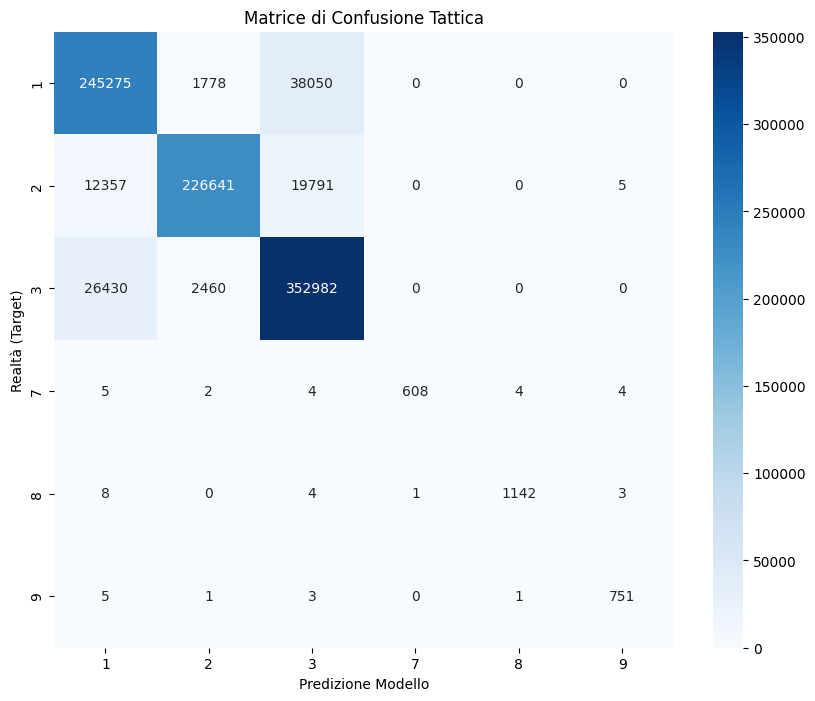


--- Report Classificazione ---
              precision    recall  f1-score   support

           1       0.86      0.86      0.86    285103
           2       0.98      0.88      0.93    258794
           3       0.86      0.92      0.89    381872
           7       1.00      0.97      0.98       627
           8       1.00      0.99      0.99      1158
           9       0.98      0.99      0.99       761

    accuracy                           0.89    928315
   macro avg       0.95      0.93      0.94    928315
weighted avg       0.89      0.89      0.89    928315



In [5]:
import torch
import torch.nn as nn
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def tuning_validate_and_analyze(model, val_loader, dataset):
    """
    Runs detailed evaluation on the Validation Set with Loss Breakdown.
    """
    model.eval()
    
    # 1. Define Loss Function (Same as training)
    # Assuming ignore_index=0 for padding
    criterion = nn.CrossEntropyLoss(ignore_index=0, reduction='sum') 
    
    # Trackers
    total_loss_d = 0.0
    total_loss_dp = 0.0
    total_loss_tp = 0.0
    total_samples_d = 0
    total_samples_dp = 0
    total_samples_tp = 0
    
    # Store preds/targets for metrics
    all_preds_d, all_targets_d = [], []
    all_preds_dp, all_targets_dp = [], []
    all_preds_tp, all_targets_tp = [], []
    
    print("\n📉 Running Deep Dive Validation (Tuning Analysis)...")
    
    with torch.no_grad():
        for batch in val_loader:
            # Move to Device
            x_z = batch['x_zone'].to(DEVICE)
            x_t = batch['x_type'].to(DEVICE)
            x_c = batch['context'].to(DEVICE)
            x_s = batch['x_s_id'].to(DEVICE)
            x_r = batch['x_r_id'].to(DEVICE)
            
            y_d = batch['y_dir'].to(DEVICE)
            y_dp = batch['y_depth'].to(DEVICE)
            y_tp = batch['y_type'].to(DEVICE)
            
            # Forward Pass
            l_d, l_dp, l_tp = model(x_z, x_t, x_c, x_s, x_r)
            
            # --- CALCULATE LOSS BREAKDOWN ---
            # Reshape for CrossEntropy: (Batch*Seq, Classes) vs (Batch*Seq)
            # We use reduction='sum' and divide by non-zero count to get exact average
            
            # Direction Loss
            mask_d = y_d.view(-1) != 0
            loss_d = criterion(l_d.view(-1, l_d.shape[-1]), y_d.view(-1))
            total_loss_d += loss_d.item()
            total_samples_d += mask_d.sum().item()
            
            # Depth Loss
            mask_dp = y_dp.view(-1) != 0
            loss_dp = criterion(l_dp.view(-1, l_dp.shape[-1]), y_dp.view(-1))
            total_loss_dp += loss_dp.item()
            total_samples_dp += mask_dp.sum().item()

            # Type Loss
            mask_tp = y_tp.view(-1) != 0
            loss_tp = criterion(l_tp.view(-1, l_tp.shape[-1]), y_tp.view(-1))
            total_loss_tp += loss_tp.item()
            total_samples_tp += mask_tp.sum().item()

            # --- COLLECT PREDICTIONS ---
            all_preds_d.extend(l_d.argmax(-1).view(-1)[mask_d].cpu().numpy())
            all_targets_d.extend(y_d.view(-1)[mask_d].cpu().numpy())
            
            all_preds_dp.extend(l_dp.argmax(-1).view(-1)[mask_dp].cpu().numpy())
            all_targets_dp.extend(y_dp.view(-1)[mask_dp].cpu().numpy())
            
            all_preds_tp.extend(l_tp.argmax(-1).view(-1)[mask_tp].cpu().numpy())
            all_targets_tp.extend(y_tp.view(-1)[mask_tp].cpu().numpy())

    # Calculate Average Losses
    avg_loss_d = total_loss_d / max(1, total_samples_d)
    avg_loss_dp = total_loss_dp / max(1, total_samples_dp)
    avg_loss_tp = total_loss_tp / max(1, total_samples_tp)
    avg_total = avg_loss_d + avg_loss_dp + avg_loss_tp

    print(f"\n📊 LOSS BREAKDOWN (Lower is Better)")
    print(f"   Total Comb Loss: {avg_total:.4f}")
    print(f"   ---------------------------")
    print(f"   Direction Loss:  {avg_loss_d:.4f}")
    print(f"   Depth Loss:      {avg_loss_dp:.4f}")
    print(f"   Type Loss:       {avg_loss_tp:.4f}")
    print(f"   ---------------------------")
    
    # Interpretation Helper
    worst_task = max([('Direction', avg_loss_d), ('Depth', avg_loss_dp), ('Type', avg_loss_tp)], key=lambda x: x[1])
    print(f"   👉 TUNING TIP: Your model struggles most with {worst_task[0]}.") 
    print(f"      Try increasing the loss weight for {worst_task[0]} or checking class imbalance there.")

    # --- DETAILED REPORTS ---
    
    # 1. Direction Report
    print("\n=== VAL DIRECTION REPORT ===")
    d_labels = [k for k,v in dataset.dir_vocab.items() if v in np.unique(all_targets_d) and k not in ['<pad>', '0']]
    d_indices = [dataset.dir_vocab[k] for k in d_labels]
    print(classification_report(all_targets_d, all_preds_d, labels=d_indices, target_names=d_labels, zero_division=0))
    
    # 2. Depth Report
    print("\n=== VAL DEPTH REPORT ===")
    dp_labels = [k for k,v in dataset.depth_vocab.items() if v in np.unique(all_targets_dp) and k not in ['<pad>', '0']]
    dp_indices = [dataset.depth_vocab[k] for k in dp_labels]
    print(classification_report(all_targets_dp, all_preds_dp, labels=dp_indices, target_names=dp_labels, zero_division=0))
    
    # 3. Shot Type Report
    print("\n=== VAL SHOT TYPE REPORT ===")
    tp_labels = [k for k,v in dataset.shot_vocab.items() if v in np.unique(all_targets_tp) and k not in ['<pad>']]
    tp_indices = [dataset.shot_vocab[k] for k in tp_labels]
    print(classification_report(all_targets_tp, all_preds_tp, labels=tp_indices, target_names=tp_labels, zero_division=0))

    # Confusion Matrix (Direction)
    cm = confusion_matrix(all_targets_d, all_preds_d, labels=d_indices)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=d_labels, yticklabels=d_labels)
    plt.title('Validation: Direction Confusion Matrix')
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.show()

# Example Usage:
tuning_validate_and_analyze(model, val_loader, dataset)

### Normal weights, no L/R, men dataset:
```
              precision    recall  f1-score   support

           1       0.81      0.92      0.86    285103
           2       0.98      0.88      0.93    258794
           3       0.90      0.88      0.89    381872
           7       1.00      0.97      0.98       627
           8       0.98      0.99      0.98      1158
           9       0.98      0.98      0.98       761

   micro avg       0.89      0.89      0.89    928315
   macro avg       0.63      0.62      0.62    928315
weighted avg       0.90      0.89      0.89    928315
```
(note, due to wrong weights the macro avg is not correct here)

### Custom weights, no L/R, men dataset:
```
--- Report Classificazione ---
              precision    recall  f1-score   support

           1       0.84      0.88      0.86    285103
           2       0.99      0.87      0.93    258794
           3       0.87      0.91      0.89    381872
           7       0.99      0.98      0.98       627
           8       0.99      0.99      0.99      1158
           9       0.99      0.98      0.99       761

    accuracy                           0.89    928315
   macro avg       0.95      0.94      0.94    928315
weighted avg       0.90      0.89      0.89    928315

```
(accuracy is the same as micro avg from before)


In [10]:
def calculate_top_k(model, loader, k=3):
    model.eval()
    correct_topk = 0
    total = 0
    
    with torch.no_grad():
        for batch in loader:
            x_z = batch['x_zone'].to(DEVICE)
            x_t = batch['x_type'].to(DEVICE)
            x_c = batch['context'].to(DEVICE)
            y = batch['y_target'].to(DEVICE)
            
            logits = model(x_z, x_t, x_c)
            
            # Mask padding
            mask = (y != 0)
            flat_logits = logits[mask] # [N_valid, Vocab]
            flat_y = y[mask]           # [N_valid]
            
            # Top-K
            _, topk_indices = flat_logits.topk(k, dim=1) # [N, k]
            
            # Controlla se il target è in una delle k predizioni
            # Espandiamo y per confrontarlo: [N, 1]
            correct_topk += topk_indices.eq(flat_y.unsqueeze(1)).sum().item()
            total += flat_y.size(0)
            
    print(f"Top-{k} Accuracy: {correct_topk/total*100:.2f}%")

# Esegui
calculate_top_k(model, full_loader, k=1)

Top-1 Accuracy: 89.13%


In [9]:
def predict_next_shot(rally_str, surface='Hard', score='0-0', is_second_serve=False, server_hand='R', receiver_hand='R'):
    """
    New optional args: server_hand='R' or 'L', receiver_hand='R' or 'L'
    """
    # 1. Parsing (Unchanged)
    shots = rally_str.split(' ')
    seq_z, seq_t = [], []
    
    shot_vocab = dataset.shot_vocab
    zone_vocab = dataset.zone_vocab
    pattern = re.compile(r'([0-9]*)([a-zA-Z])([0-9]*)')
    
    last_tgt = 0
    for s in shots:
        m = pattern.search(s)
        if not m: continue
        ac, sc, tc = m.groups()
        
        arr = zone_vocab.get(ac, 0) if ac else last_tgt
        typ = shot_vocab.get(sc.lower(), 0)
        tgt = zone_vocab.get(tc, 0) if tc else 0
        last_tgt = tgt
        
        if typ != 0:
            seq_z.append(arr)
            seq_t.append(typ)
    
    # 2. Tensor Prep (Unchanged)
    L = len(seq_z)
    pad_len = SEQ_LEN - L
    if pad_len < 0: 
        seq_z = seq_z[-SEQ_LEN:]
        seq_t = seq_t[-SEQ_LEN:]
        pad_len = 0
        
    inp_z = torch.tensor([0]*pad_len + seq_z, dtype=torch.long).unsqueeze(0).to(DEVICE)
    inp_t = torch.tensor([0]*pad_len + seq_t, dtype=torch.long).unsqueeze(0).to(DEVICE)
    
    # 3. Context Prep (Updated for 6 Features)
    surf_idx = dataset.surface_vocab.get(surface, 1)
    
    try:
        s_srv, s_rcv = score.split('-')
        score_server = dataset.score_map.get(s_srv, 0)
        score_receiver = dataset.score_map.get(s_rcv, 0)
    except:
        score_server, score_receiver = 0, 0
        
    is_2nd = 1 if is_second_serve else 0
    
    # --- NEW: Handedness Mapping ---
    s_hand_idx = dataset.hand_vocab.get(server_hand, 1) # Default 1 (Right)
    r_hand_idx = dataset.hand_vocab.get(receiver_hand, 1) # Default 1 (Right)
    
    # Vector size is now 6: [Surf, Sc1, Sc2, 2nd, Hand1, Hand2]
    context_vec = [surf_idx, score_server, score_receiver, is_2nd, s_hand_idx, r_hand_idx]
    inp_c = torch.tensor([context_vec], dtype=torch.float32).to(DEVICE)
    
    # 4. Predict (Unchanged)
    model.eval()
    with torch.no_grad():
        logits = model(inp_z, inp_t, inp_c) 
        probs = torch.softmax(logits[0, -1, :], dim=0)
        
    # 5. Output
    print(f"\nScambio: {rally_str}")
    print(f"Ctx: {surface} | {score} | {server_hand} v {receiver_hand}")
    
    idx_to_zone = {v: k for k, v in zone_vocab.items()}
    top_probs, top_idxs = torch.topk(probs, 3)
    
    for p, idx in zip(top_probs, top_idxs):
        idx = idx.item()
        if idx == 0: continue
        print(f"Zona {idx_to_zone.get(idx, '?')}: {p.item()*100:.1f}%")

# --- Test Scenarios ---
print("Test 1: Standard Hard Court")
predict_next_shot("6s 2f") 

print("\nTest 2: Pressure Point on Clay (Longer rallies expected?)")
predict_next_shot("4s 1f 4b 3f", surface='Clay', score='30-40') 

print("\nTest 3: 2nd Serve Return")
predict_next_shot("5s", surface='Grass', is_second_serve=True)

Test 1: Standard Hard Court

Scambio: 6s 2f
Ctx: Hard | 0-0 | R v R
Zona 3: 48.9%
Zona 1: 46.7%
Zona 2: 4.5%

Test 2: Pressure Point on Clay (Longer rallies expected?)

Scambio: 4s 1f 4b 3f
Ctx: Clay | 30-40 | R v R
Zona 3: 48.6%
Zona 1: 41.4%
Zona 2: 10.0%

Test 3: 2nd Serve Return

Scambio: 5s
Ctx: Grass | 0-0 | R v R
Zona 3: 43.3%
Zona 2: 32.9%
Zona 1: 23.8%



--- Training Wei et al. (2016) Random Forest Baseline ---
Flattening sequences into Shot-by-Shot dataset...
  Training Shots: 743556
  Validation Shots: 184759
Evaluating...

Baseline Accuracy: 45.13%

--- Detailed Report (matches paper's Discrete Region analysis) ---
              precision    recall  f1-score   support

           1       0.43      0.61      0.50     57004
           2       0.40      0.26      0.32     51587
           3       0.52      0.46      0.49     75651
           7       0.07      0.36      0.12       128
           8       0.13      0.30      0.18       231
           9       0.08      0.32      0.13       158

    accuracy                           0.45    184759
   macro avg       0.27      0.39      0.29    184759
weighted avg       0.46      0.45      0.44    184759



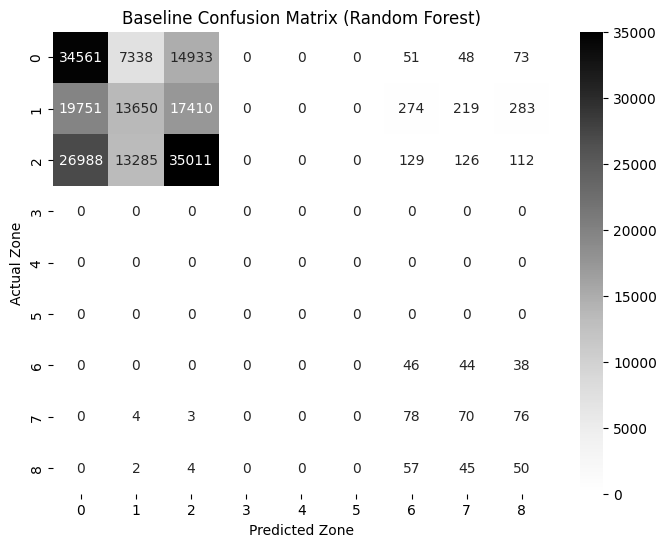

In [11]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def run_wei_baseline(dataset, train_ids, val_ids):
    """
    Implements the Baseline from Wei et al. (2016) using Random Forests.
    Ref: 'Forecasting the Next Shot Location in Tennis', Section 6.3.2 
    """
    print(f"\n--- Training Wei et al. (2016) Random Forest Baseline ---")
    
    # --- 1. FEATURE EXTRACTION ---
    # The paper treats prediction as a classification/regression problem on the 
    # immediate previous state. We must flatten your sequences.
    
    def flatten_data(indices):
        X_flat = [] # Features
        y_flat = [] # Targets
        
        # Create a loader for this subset
        subset = Subset(dataset, indices)
        loader = DataLoader(subset, batch_size=256, shuffle=False, num_workers=0)
        
        for batch in loader:
            # Inputs: [Batch, Seq_Len]
            x_z = batch['x_zone'].numpy() 
            x_t = batch['x_type'].numpy()
            context = batch['context'].numpy() # [Batch, 6]
            
            # Target: [Batch, Seq_Len]
            y = batch['y_target'].numpy()
            
            B, L = x_z.shape
            
            for i in range(B):
                # Context is constant for the whole rally, so we repeat it
                # Context: [Surface, Sc1, Sc2, Is2nd, Hand1, Hand2]
                ctx_vec = context[i] 
                
                # Iterate through the sequence time-steps
                for t in range(L):
                    target_zone = y[i, t]
                    
                    # Ignore Padding (0)
                    if target_zone == 0:
                        continue
                        
                    # PAPER LOGIC: 
                    # Prediction depends on Previous Shot Info + Context [cite: 240]
                    prev_zone = x_z[i, t]
                    prev_type = x_t[i, t]
                    
                    # Create Feature Vector: [Prev_Zone, Prev_Type, Surface, Score1, Score2, 2ndSrv, Hand1, Hand2]
                    # This maps the paper's "Raw Features" + "Match Context" to your data
                    feature_row = np.concatenate(([prev_zone, prev_type], ctx_vec))
                    
                    X_flat.append(feature_row)
                    y_flat.append(target_zone)
                    
        return np.array(X_flat), np.array(y_flat)

    print("Flattening sequences into Shot-by-Shot dataset...")
    X_train, y_train = flatten_data(train_ids)
    X_val, y_val = flatten_data(val_ids)
    
    print(f"  Training Shots: {X_train.shape[0]}")
    print(f"  Validation Shots: {X_val.shape[0]}")

    # --- 2. TRAINING ---
    # "We utilized a Random Decision Forest... which is robust against overfitting" 
    # The paper uses 100 trees for their experiments (Section 8.3) [cite: 441]
    rf_model = RandomForestClassifier(
        n_estimators=100,  # As per paper [cite: 441]
        max_depth=None,    # Let trees grow deep to capture "Style" dictionaries
        n_jobs=-1,
        random_state=42,
        class_weight='balanced' # Optional: Helps with rare zones (7,8,9)
    )
    
    rf_model.fit(X_train, y_train)
    
    # --- 3. EVALUATION ---
    print("Evaluating...")
    val_preds = rf_model.predict(X_val)
    
    # Metrics
    acc = accuracy_score(y_val, val_preds)
    print(f"\nBaseline Accuracy: {acc*100:.2f}%")
    
    # Classification Report (Focus on Zones 1-9)
    target_names = [str(i) for i in sorted(np.unique(y_val))]
    print("\n--- Detailed Report (matches paper's Discrete Region analysis) ---")
    print(classification_report(y_val, val_preds, target_names=target_names, zero_division=0))
    
    # Visual Confusion Matrix
    cm = confusion_matrix(y_val, val_preds, labels=[1, 2, 3, 4, 5, 6, 7, 8, 9])
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greys')
    plt.title("Baseline Confusion Matrix (Random Forest)")
    plt.xlabel("Predicted Zone")
    plt.ylabel("Actual Zone")
    plt.show()
    
    return rf_model

# --- EXECUTE ---
# Uses the first fold split from your K-Fold setup
train_idx, val_idx = next(kfold.split(np.arange(len(dataset))))
rf_baseline = run_wei_baseline(dataset, train_idx, val_idx)

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score
import numpy as np

# --- 1. MODEL CLASS ---
class MultiTaskLSTM_Baseline(nn.Module):
    def __init__(self, dir_vocab_size, depth_vocab_size, type_vocab_size, context_dim=6, 
                 embed_dim=64, hidden_dim=256, num_layers=2):
        super().__init__()
        
        # Input: Direction + Type + Context
        self.input_dim = embed_dim * 3
        
        # Embeddings
        self.dir_emb = nn.Embedding(dir_vocab_size, embed_dim, padding_idx=0)
        self.type_emb = nn.Embedding(type_vocab_size, embed_dim, padding_idx=0)
        self.context_fc = nn.Linear(context_dim, embed_dim)
        
        # LSTM
        self.lstm = nn.LSTM(
            input_size=self.input_dim, 
            hidden_size=hidden_dim, 
            num_layers=num_layers, 
            batch_first=True, 
            dropout=0.1
        )
        
        # Output Heads
        self.head_dir = nn.Linear(hidden_dim, dir_vocab_size)
        self.head_depth = nn.Linear(hidden_dim, depth_vocab_size)
        self.head_type = nn.Linear(hidden_dim, type_vocab_size)

    def forward(self, x_d, x_t, x_c):
        d = self.dir_emb(x_d)
        t = self.type_emb(x_t)
        c = self.context_fc(x_c).unsqueeze(1).expand(-1, d.size(1), -1)
        
        x = torch.cat([d, t, c], dim=-1)
        lstm_out, _ = self.lstm(x)
        
        out_dir = self.head_dir(lstm_out)
        out_depth = self.head_depth(lstm_out)
        out_type = self.head_type(lstm_out)
        
        return out_dir, out_depth, out_type

# --- 2. EVALUATION HELPER ---
def evaluate_baseline(model, loader, dataset, device):
    model.eval()
    correct_d, total_d = 0, 0
    correct_dp, total_dp = 0, 0
    correct_t, total_t = 0, 0
    
    with torch.no_grad():
        for batch in loader:
            x_d = batch['x_zone'].to(device)
            x_t = batch['x_type'].to(device)
            x_c = batch['context'].to(device)
            
            y_d = batch['y_dir'].to(device)
            y_dp = batch['y_depth'].to(device)
            y_t = batch['y_type'].to(device)
            
            pred_d, pred_dp, pred_t = model(x_d, x_t, x_c)
            
            # Direction Accuracy
            mask_d = (y_d != 0).view(-1)
            if mask_d.sum() == 0: continue
            
            p_d = pred_d.argmax(dim=-1).view(-1)[mask_d]
            correct_d += (p_d == y_d.view(-1)[mask_d]).sum().item()
            total_d += mask_d.sum().item()
            
            # Depth Accuracy
            mask_dp = (y_dp != 0).view(-1)
            p_dp = pred_dp.argmax(dim=-1).view(-1)[mask_dp]
            correct_dp += (p_dp == y_dp.view(-1)[mask_dp]).sum().item()
            total_dp += mask_dp.sum().item()
            
            # Type Accuracy
            mask_t = (y_t != 0).view(-1)
            p_t = pred_t.argmax(dim=-1).view(-1)[mask_t]
            correct_t += (p_t == y_t.view(-1)[mask_t]).sum().item()
            total_t += mask_t.sum().item()
            
    return {
        'dir': (correct_d / total_d * 100) if total_d > 0 else 0,
        'depth': (correct_dp / total_dp * 100) if total_dp > 0 else 0,
        'type': (correct_t / total_t * 100) if total_t > 0 else 0
    }

# --- 3. TRAINING LOOP ---
def train_multitask_baseline(dataset, epochs=10, batch_size=64, lr=1e-3, device='cuda'):
    print(f"--- STARTING MULTI-TASK LSTM BASELINE (80/10/10 Split) ---")
    
    # Split Dataset
    total_len = len(dataset)
    train_len = int(0.8 * total_len)
    val_len = int(0.1 * total_len)
    test_len = total_len - train_len - val_len
    
    train_ds, val_ds, test_ds = random_split(
        dataset, [train_len, val_len, test_len], 
        generator=torch.Generator().manual_seed(42)
    )
    
    print(f"Train: {len(train_ds)} | Val: {len(val_ds)} | Test: {len(test_ds)}")
    
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=0)
    
    # Initialize Model
    model = MultiTaskLSTM_Baseline(
        dir_vocab_size=len(dataset.dir_vocab),
        depth_vocab_size=len(dataset.depth_vocab),
        type_vocab_size=len(dataset.shot_vocab),
        context_dim=6
    ).to(device)
    
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss(ignore_index=0)
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        
        for batch in train_loader:
            x_d = batch['x_zone'].to(device)
            x_t = batch['x_type'].to(device)
            x_c = batch['context'].to(device)
            
            y_d = batch['y_dir'].to(device)
            y_dp = batch['y_depth'].to(device)
            y_t = batch['y_type'].to(device)
            
            optimizer.zero_grad()
            
            pred_d, pred_dp, pred_t = model(x_d, x_t, x_c)
            
            l_d = criterion(pred_d.view(-1, len(dataset.dir_vocab)), y_d.view(-1))
            l_dp = criterion(pred_dp.view(-1, len(dataset.depth_vocab)), y_dp.view(-1))
            l_t = criterion(pred_t.view(-1, len(dataset.shot_vocab)), y_t.view(-1))
            
            loss = l_d + l_dp + l_t
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            
        avg_train_loss = total_loss / len(train_loader)
        val_metrics = evaluate_baseline(model, val_loader, dataset, device)
        
        print(f"Ep {epoch+1}/{epochs} | Loss: {avg_train_loss:.4f} | "
              f"Val Dir: {val_metrics['dir']:.1f}% | "
              f"Val Depth: {val_metrics['depth']:.1f}% | "
              f"Val Type: {val_metrics['type']:.1f}%")

    # Final Test
    print("\n--- Running Final Evaluation on Test Set ---")
    test_metrics = evaluate_baseline(model, test_loader, dataset, device)
    
    print(f"TEST RESULTS:")
    print(f"Direction Accuracy: {test_metrics['dir']:.2f}%")
    print(f"Depth Accuracy:     {test_metrics['depth']:.2f}%")
    print(f"Shot Type Accuracy: {test_metrics['type']:.2f}%")

    # Save
    save_file = "multitask_lstm_baseline.pth"
    torch.save(model.state_dict(), save_file)
    print(f"Baseline model saved to {save_file}")
    
    return model

# --- EXECUTE ---
if __name__ == "__main__":
    # Assuming 'dataset' and 'DEVICE' are already defined
    base_path = '../dataset/tennis_MatchChartingProject-master/'

    # List all point files to merge
    point_files = [
        base_path + 'charting-m-points-2020s.csv',
        base_path + 'charting-m-points-2010s.csv',
        base_path + 'charting-m-points-to-2009.csv'
    ]
    
    # New Matches File
    matches_path = '../dataset/tennis_MatchChartingProject-master/charting-m-matches.csv'

    atp_path = '../dataset/atp_players.csv'
    wta_path = '../dataset/wta_players.csv'
    dataset = MCPTennisDataset(point_files, matches_path, atp_path, wta_path, max_seq_len=SEQ_LEN) 
    # baseline_model = train_multitask_baseline(dataset, epochs=10, batch_size=64, device=DEVICE)

Initializing Dataset with CORRECTED Parsing Logic...


C:\Users\soyka\AppData\Local\Temp\ipykernel_21624\71657521.py:100: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, encoding='utf-8', on_bad_lines='skip')
C:\Users\soyka\AppData\Local\Temp\ipykernel_21624\71657521.py:100: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, encoding='utf-8', on_bad_lines='skip')


Parsing Rallies into Unified Tokens...
Dataset Built. Unique Unified Shots Found: 279


In [4]:
# --- LOAD CHECKPOINT ---

checkpoint_path = "../checkpoints/multitask_lstm_baseline.pth"

# Ricrea il modello con gli stessi parametri della fase di training
model = MultiTaskLSTM_Baseline(
    dir_vocab_size=len(dataset.dir_vocab),
    depth_vocab_size=len(dataset.depth_vocab),
    type_vocab_size=len(dataset.shot_vocab),
    context_dim=6
).to(DEVICE)

# Carica i pesi
model.load_state_dict(torch.load(checkpoint_path, map_location=DEVICE))

# Metti il modello in evaluation mode
model.eval()

print("Checkpoint loaded successfully!")


AttributeError: 'MCPTennisDataset' object has no attribute 'dir_vocab'

In [3]:
def get_balanced_weights(target_tensor, num_classes, power=0.3):
    # 1. Flatten the big tensor directly (Very fast)
    flat = target_tensor.view(-1).numpy()
    
    # 2. Filter padding (0)
    valid = flat[flat != 0]
    
    # 3. Compute Weights
    unique = np.unique(valid)
    raw_weights = compute_class_weight(class_weight='balanced', classes=unique, y=valid)
    smoothed_weights = raw_weights ** power
    
    weights_list = [0.0] # Index 0 is padding
    for i in range(1, num_classes + 1):
        if i in unique:
            idx = np.where(unique == i)[0][0]
            weights_list.append(float(smoothed_weights[idx]))
        else:
            weights_list.append(1.0)
            
    # Cap weights
    MAX_WEIGHT = 15.0
    weights_list = [min(w, MAX_WEIGHT) for w in weights_list]
    return torch.tensor(weights_list, dtype=torch.float32).to(DEVICE)


# --- 1. CALCULATE WEIGHTS FOR THE UNIFIED TOKENS ---
print("\nCalculating Balanced Weights for Unified Vocab...")

# We now have just ONE target tensor: y_target_tensor
# It contains IDs like 42 (which represents "Forehand_CrossCourt_Deep")
w_unified = get_balanced_weights(dataset.y_target_tensor, len(dataset.unified_vocab))
print(f"Unified Weights Shape: {w_unified.shape}")
    
# --- SPLIT BY MATCH ---
print("\nSplitting Data (80/15/5)...")
all_matches = sorted(list(set(dataset.sample_match_ids)))

train_matches, temp_matches = train_test_split(all_matches, test_size=0.20, random_state=42)
val_matches, test_matches = train_test_split(temp_matches, test_size=0.25, random_state=42)

train_set = set(train_matches)
val_set = set(val_matches)
test_set = set(test_matches)

train_indices = [i for i, m in enumerate(dataset.sample_match_ids) if m in train_set]
val_indices = [i for i, m in enumerate(dataset.sample_match_ids) if m in val_set]
test_indices = [i for i, m in enumerate(dataset.sample_match_ids) if m in test_set]

print(f"Train: {len(train_indices)} | Val: {len(val_indices)} | Test: {len(test_indices)}")



Calculating Balanced Weights for Unified Vocab...
Unified Weights Shape: torch.Size([280])

Splitting Data (80/15/5)...
Train: 763726 | Val: 144175 | Test: 50658


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split

class UnifiedCristianGPT(nn.Module):
    def __init__(self, vocab_size, num_players, context_dim=10, embed_dim=64, n_head=4, n_cycles=3, seq_len=30):        
        super().__init__()
        self.n_cycles = n_cycles
        
        # 1. Embeddings
        # We only need ONE embedding layer because the dataset merged Type+Depth+Dir
        self.token_emb = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.player_emb = nn.Embedding(num_players, 64) 
        
        # 2. Context Fusion
        # Context dim is 10 in your new dataset
        self.context_fusion = nn.Sequential(
            nn.Linear(context_dim + (64 * 2), embed_dim), 
            nn.ReLU(),
            nn.Linear(embed_dim, embed_dim)
        )
        
        # 3. Input Dimension
        # Input = Token(embed_dim) + Context(embed_dim)
        self.input_dim = embed_dim * 2
        
        # 4. Position Embedding
        self.pos_emb = nn.Parameter(torch.randn(1, seq_len, self.input_dim))
        
        # 5. Transformer
        self.shared_block = nn.TransformerEncoderLayer(
            d_model=self.input_dim, nhead=n_head, dim_feedforward=embed_dim * 4,
            batch_first=True, norm_first=True, dropout=0.1
        )
        
        self.norm_f = nn.LayerNorm(self.input_dim)
        
        # 6. Output Head (Predicts next Unified Token)
        self.head = nn.Linear(self.input_dim, vocab_size)

    def generate_causal_mask(self, sz):
        # Prevent looking at future tokens
        return torch.triu(torch.full((sz, sz), float('-inf')), diagonal=1).to(DEVICE)
    
    def forward(self, x_seq, x_c, x_s, x_r):
        # Embed Sequence
        tok = self.token_emb(x_seq) 
        
        # Embed Players
        s_emb = self.player_emb(x_s)
        r_emb = self.player_emb(x_r)
        
        # Fuse Context
        c_combined = torch.cat([x_c, s_emb, r_emb], dim=1) 
        c = self.context_fusion(c_combined) 
        
        # Broadcast Context to sequence length
        c = c.unsqueeze(1).expand(-1, tok.size(1), -1)
        
        # Concatenate: [Token, Context]
        x = torch.cat([tok, c], dim=-1) 
        x = x + self.pos_emb[:, :x.size(1), :]
        
        # Causal Mask
        mask = self.generate_causal_mask(x.size(1))
        
        # Transformer Pass
        memory = x.clone()
        for _ in range(self.n_cycles):
            memory = self.shared_block(memory, src_mask=mask)
            
        # Prediction
        logits = self.head(self.norm_f(memory))
        
        return logits

In [5]:
checkpoint_path = "../checkpoints/unified_transformer_model.pth"
print(f"🔄 Loading model from {checkpoint_path}...")
    
if not os.path.exists(checkpoint_path):
    raise FileNotFoundError(f"Checkpoint not found at {checkpoint_path}")

# 1. Get Dimensions from Dataset
vocab_size = len(dataset.unified_vocab)
num_players = len(dataset.player_vocab)

print(f"   Vocab Size: {vocab_size}")
print(f"   Num Players: {num_players}")

# 2. Instantiate Model architecture
model = UnifiedCristianGPT(
    vocab_size=vocab_size,
    num_players=num_players,
    seq_len=SEQ_LEN
).to(DEVICE)

# 3. Load Weights
state_dict = torch.load(checkpoint_path, map_location=DEVICE)
model.load_state_dict(state_dict)

# 4. Set to Evaluation Mode
model.eval()

print("✅ Model loaded successfully and set to eval mode.")

🔄 Loading model from ../checkpoints/unified_transformer_model.pth...
   Vocab Size: 279
   Num Players: 128022
✅ Model loaded successfully and set to eval mode.



--- PLAYER FREQUENCY ANALYSIS (50658 samples) ---
Gathering player stats and predictions...


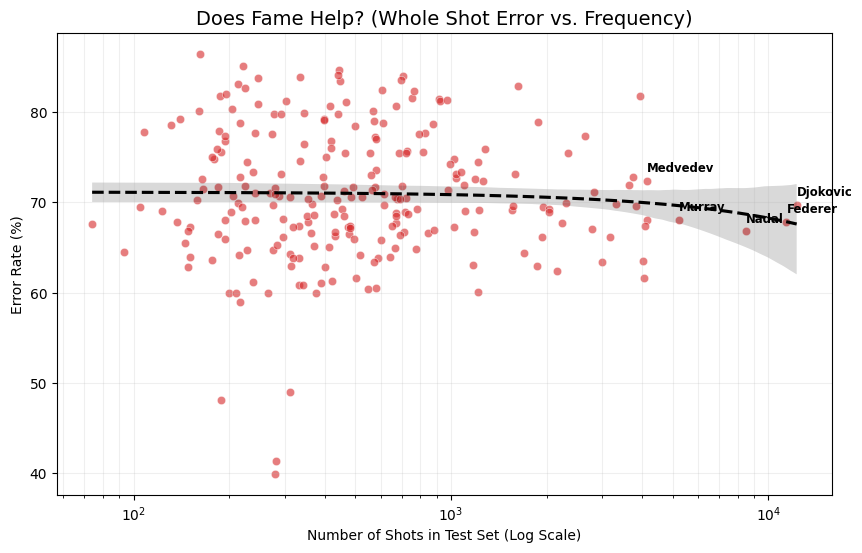


Analyzed 237 unique players (with >15 shots).
Correlation between Frequency and Error Rate: -0.0580


In [14]:
import os
import random
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter

# Define Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==============================================================================
# 0. HELPER: DECODER MAP & VIRTUAL VOCABS
# ==============================================================================
def get_fast_decoder_map(dataset):
    """
    1. Creates a map: Unified_ID -> (Type_ID, Direction_ID, Depth_ID)
    2. Patches the dataset object to include missing vocab attributes 
       (dir_vocab, shot_vocab, etc.) so the reporting functions don't crash.
    """
    
    # --- A. PATCH DATASET IF MISSING AUXILIARY VOCABS ---
    # The evaluation report needs these to know that 'f' means 'Forehand' etc.
    if not hasattr(dataset, 'shot_vocab'):
        # Define standard tennis mapping based on your parsing logic
        dataset.shot_vocab = {
            '<pad>': 0, 'Serve': 1, 'Forehand': 2, 'Backhand': 3, 
            'Volley': 4, 'Smash': 5, 'Slice': 6, 'Return': 7, 
            'Lob': 8, 'Drop': 9, 'Unknown': 10
        }
        # Map raw chars (f, b, r, s) to these keys for the decoder
        dataset.char_to_shot = {
            'f': 'Forehand', 'b': 'Backhand', 'v': 'Volley', 'm': 'Smash', 
            's': 'Slice', 'r': 'Return', 'l': 'Lob', 'u': 'Slice', 'p': 'Drop', # 'u' often slice/underspin
            'Serve': 'Serve'
        }

    if not hasattr(dataset, 'dir_vocab'):
        dataset.dir_vocab = {
            '<pad>': 0, 'Wide/Right': 1, 'Body/Center': 2, 'T/Left': 3
        }
    
    if not hasattr(dataset, 'depth_vocab'):
        dataset.depth_vocab = {
            '<pad>': 0, 'Short': 1, 'Deep': 2, 'Very Deep': 3
        }

    # --- B. BUILD THE DECODER MAP ---
    if hasattr(dataset, 'id_to_components'):
        return dataset.id_to_components

    uni_map = {}
    
    # Use 'inv_unified_vocab' if it exists (from your Dataset code), else invert 'unified_vocab'
    if hasattr(dataset, 'inv_unified_vocab'):
        inv_vocab = dataset.inv_unified_vocab
    else:
        inv_vocab = {v: k for k, v in dataset.unified_vocab.items()} 
    
    for uid, token_str in inv_vocab.items():
        if uid <= 1: # Padding (0) or Unk (1)
            uni_map[uid] = (0, 0, 0)
            continue
            
        try:
            # Token format in your Dataset is: "Serve_6" or "f_1_7"
            parts = token_str.split('_')
            
            t_raw = parts[0]
            d_raw = parts[1] if len(parts) > 1 else '0'
            dp_raw = parts[2] if len(parts) > 2 else '0'
            
            # 1. Map Shot Type
            if t_raw == 'Serve':
                t_lbl = 'Serve'
            else:
                # Map 'f' -> 'Forehand'
                t_lbl = dataset.char_to_shot.get(t_raw, 'Unknown')
            t_id = dataset.shot_vocab.get(t_lbl, 0)

            # 2. Map Direction (Tennis Logic: 1/4=Right, 2/5=Center, 3/6=Left)
            # You might want to adjust this based on specific court geometry needs
            d_val = int(d_raw) if d_raw.isdigit() else 0
            if d_val in [1, 4]: d_id = 1 # Right/Wide
            elif d_val in [2, 5]: d_id = 2 # Center/Body
            elif d_val in [3, 6]: d_id = 3 # Left/T
            else: d_id = 0

            # 3. Map Depth (7=Short, 8=Deep, 9=Very Deep)
            dp_val = int(dp_raw) if dp_raw.isdigit() else 0
            if dp_val == 7: dp_id = 1
            elif dp_val == 8: dp_id = 2
            elif dp_val == 9: dp_id = 3
            else: dp_id = 0 # N/A (Serves usually don't have depth in this specific encoding)
            
            uni_map[uid] = (t_id, d_id, dp_id)
            
        except Exception as e:
            # print(f"Skipping token {token_str}: {e}")
            uni_map[uid] = (0, 0, 0)
            
    dataset.id_to_components = uni_map
    return uni_map

# ==============================================================================
# 1. LOADING
# ==============================================================================
def load_weights_into_model(model, path):
    if not os.path.exists(path):
        print(f"⚠️  Weights file '{path}' not found. Using random init.")
        return model
        
    print(f"🔍 Loading weights from '{path}'...")
    try:
        checkpoint = torch.load(path, map_location=DEVICE)
        # Handle both full checkpoint dicts and direct state_dicts
        state_dict = checkpoint['model_state_dict'] if (isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint) else checkpoint
        model.load_state_dict(state_dict)
        print("✅ Weights loaded successfully!")
    except Exception as e:
        print(f"❌ Error loading weights: {e}")
    
    return model.to(DEVICE)

# ==============================================================================
# 2. MAIN EVALUATION (Adapted for Unified Model)
# ==============================================================================
def evaluation_analyze_tactics_multitask(model, loader, dataset):
    model.eval()
    
    # Store predictions and targets for all 3 components
    all_preds_d, all_targets_d = [], []
    all_preds_dp, all_targets_dp = [], []
    all_preds_tp, all_targets_tp = [], []
    
    # Get the decoder map: ID -> (Type_ID, Dir_ID, Depth_ID)
    uni_map = get_fast_decoder_map(dataset)
    
    print("\nRunning Evaluation on TEST SET (Unified Model)...")
    with torch.no_grad():
        for batch in loader:
            # Updated inputs for UnifiedCristianGPT
            x_seq = batch['x_seq'].to(DEVICE)
            x_c = batch['context'].to(DEVICE)
            x_s = batch['x_s_id'].to(DEVICE)
            x_r = batch['x_r_id'].to(DEVICE)
            
            # Unified Target
            y_unified = batch['y_target'].to(DEVICE)
            
            # Forward Pass
            logits = model(x_seq, x_c, x_s, x_r) # [Batch, Seq, Vocab]
            
            # Get Unified Predictions
            preds_unified = logits.argmax(dim=-1) # [Batch, Seq]
            
            # Mask Padding (where target is 0)
            mask = y_unified != 0
            
            # Flatten to iterate
            valid_preds = preds_unified[mask].cpu().numpy()
            valid_targets = y_unified[mask].cpu().numpy()
            
            # DECODE: Split Unified ID back into components for reporting
            for p_uid, t_uid in zip(valid_preds, valid_targets):
                # Decode Prediction
                p_t, p_d, p_dp = uni_map.get(p_uid, (0,0,0))
                # Decode Target
                t_t, t_d, t_dp = uni_map.get(t_uid, (0,0,0))
                
                # Append to lists
                all_preds_d.append(p_d)
                all_targets_d.append(t_d)
                
                all_preds_tp.append(p_t)
                all_targets_tp.append(t_t)
                
                # Only evaluate depth if target depth is not N/A (0)
                if t_dp != 0:
                    all_preds_dp.append(p_dp)
                    all_targets_dp.append(t_dp)

    # --- REPORTS ---
    
    # 1. Direction Report
    print("\n=== DIRECTION REPORT ===")
    unique_d = np.unique(all_targets_d)
    d_labels = [k for k,v in dataset.dir_vocab.items() if v in unique_d and k not in ['<pad>', '0']]
    d_indices = [dataset.dir_vocab[k] for k in d_labels]
    print(classification_report(all_targets_d, all_preds_d, labels=d_indices, target_names=d_labels, zero_division=0))
    
    # 2. Depth Report
    print("\n=== DEPTH REPORT ===")
    unique_dp = np.unique(all_targets_dp)
    dp_labels = [k for k,v in dataset.depth_vocab.items() if v in unique_dp and k not in ['<pad>', '0']]
    dp_indices = [dataset.depth_vocab[k] for k in dp_labels]
    print(classification_report(all_targets_dp, all_preds_dp, labels=dp_indices, target_names=dp_labels, zero_division=0))
    
    # 3. Shot Type Report
    print("\n=== SHOT TYPE REPORT ===")
    unique_tp = np.unique(all_targets_tp)
    tp_labels = [k for k,v in dataset.shot_vocab.items() if v in unique_tp and k not in ['<pad>']]
    tp_indices = [dataset.shot_vocab[k] for k in tp_labels]
    print(classification_report(all_targets_tp, all_preds_tp, labels=tp_indices, target_names=tp_labels, zero_division=0))

    # Confusion Matrix for Direction
    cm = confusion_matrix(all_targets_d, all_preds_d, labels=d_indices)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=d_labels, yticklabels=d_labels)
    plt.title('Direction Confusion Matrix (Decoded from Unified)')
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.show()

# ==============================================================================
# 3. LIVE TEST CASES
# ==============================================================================
def evaluation_live_test_cases(model, dataset, test_indices, num_samples=10, print_flag=True):     
    model.eval()
    
    # Invert separate vocabs for printing
    inv_dir = {v:k for k,v in dataset.dir_vocab.items()}
    inv_typ = {v:k for k,v in dataset.shot_vocab.items()}
    
    print(f"\n--- LIVE TACTICAL EVALUATION ({num_samples} Random Test Cases) ---")
    selected_indices = random.sample(test_indices, min(num_samples, len(test_indices)))
    results_buffer = {3: [], 2:[], 1:[], 0:[]}
    
    uni_map = get_fast_decoder_map(dataset)

    with torch.no_grad():
        for idx in selected_indices:
            sample = dataset[idx]
            # Use 'x_seq' which contains unified IDs
            non_zeros = (sample['x_seq'] != 0).nonzero(as_tuple=True)[0]
            if len(non_zeros) < 2: continue
            valid_indices = non_zeros.tolist()
            t = random.choice(valid_indices)
            
            x_seq = sample['x_seq'].unsqueeze(0).to(DEVICE)
            x_c = sample['context'].unsqueeze(0).to(DEVICE)
            x_s = sample['x_s_id'].unsqueeze(0).to(DEVICE)
            x_r = sample['x_r_id'].unsqueeze(0).to(DEVICE)
            
            # Forward Pass
            logits = model(x_seq, x_c, x_s, x_r)
            
            # Construct History String (Decoding previous shots)
            start_idx = valid_indices[0]
            history_str = ""
            for i in range(start_idx, t + 1):
                uid = sample['x_seq'][i].item()
                typ, d, dep = uni_map.get(uid, (0,0,0))
                z_in = inv_dir.get(d, '?')
                t_in = inv_typ.get(typ, '?')
                if i == start_idx:
                    history_str += f"[Serve {z_in}] " if t_in == 'Serve' else f"[{t_in}{z_in}] "
                else:
                    history_str += f"-> {t_in}{z_in} "

            # Prediction
            probs = torch.softmax(logits[0, t], dim=0)
            pred_uid = probs.argmax().item()
            conf = probs.max().item() * 100
            
            # Decode Prediction
            pred_t, pred_d, pred_dp = uni_map.get(pred_uid, (0,0,0))
            
            # Get True Target
            true_uid = sample['y_target'][t].item()
            true_t, true_d, true_dp = uni_map.get(true_uid, (0,0,0))
            
            s_pred_d = inv_dir.get(pred_d, '?'); s_pred_t = inv_typ.get(pred_t, '?')
            s_true_d = inv_dir.get(true_d, '?'); s_true_t = inv_typ.get(true_t, '?')
            
            check_d = "✅" if pred_d == true_d else "❌"
            check_t = "✅" if pred_t == true_t else "❌"
            check_dp = "✅" if pred_dp == true_dp else "❌"
            
            # Decode Depth Label (assuming index 1=Shallow, 2=Deep, etc.)
            def d_lbl(x):
                # Adjust these checks based on your depth vocabulary indices
                if x == 0: return "N/A"
                if x == dataset.depth_vocab.get('Shallow', -1): return "Short"
                if x == dataset.depth_vocab.get('Deep', -1): return "Deep"
                return str(x)
            
            score = (1 if pred_d == true_d else 0) + (1 if pred_t == true_t else 0) + (1 if pred_dp == true_dp else 0)
            
            out = []
            mid = dataset.sample_match_ids[idx]
            out.append(f"\nMatch {mid}:")
            out.append(f"  History:    {history_str}")
            out.append(f"  Prediction: {s_pred_t} to {s_pred_d} ({d_lbl(pred_dp)}) | Conf: {conf:.0f}%")
            out.append(f"  ACTUAL:     {s_true_t} to {s_true_d} ({d_lbl(true_dp)}) | {check_t} Type {check_d} Dir {check_dp} Dep")
            results_buffer[score].append("\n".join(out))

    for s in [3,2,1,0]:
        items = results_buffer[s]
        if not items: continue
        print(f"\n{'='*20} {s}/3 CORRECT ({len(items)} cases) {'='*20}")
        if print_flag:
            for item in items: print(item)

# ==============================================================================
# 4. LENGTH VS ERROR
# ==============================================================================
def evaluation_length_vs_errrors(model, dataset, test_indices, num_matches=10):
    model.eval()
    
    # 1. Calculate Baselines
    print("Calculating dataset baselines...")
    from collections import Counter
    all_d, all_dp, all_tp = [], [], []
    
    check_indices = test_indices[:5000] if len(test_indices) > 5000 else test_indices
    uni_map = get_fast_decoder_map(dataset)
    
    for i in check_indices:
        y_seq = dataset[i]['y_target']
        for uid in y_seq:
            if uid.item() <= 1: continue
            t, d, dep = uni_map.get(uid.item(), (0,0,0))
            all_tp.append(t)
            all_d.append(d)
            if dep != 0: all_dp.append(dep)

    def calc_baseline(data_list):
        if not data_list: return 0.33
        counts = Counter(data_list)
        total = sum(counts.values())
        return sum([(c/total)**2 for c in counts.values()])

    base_d = calc_baseline(all_d)
    base_dp = calc_baseline(all_dp)
    base_tp = calc_baseline(all_tp)
    
    base_pair_avg = (base_d*base_dp + base_d*base_tp + base_tp*base_dp) / 3
    base_whole = base_d * base_dp * base_tp
    
    print(f"Baselines -> Dir: {base_d:.2f}, Depth: {base_dp:.2f}, Type: {base_tp:.2f}, Whole: {base_whole:.4f}")
    
    # 2. Analysis Loop
    test_match_ids = [dataset.sample_match_ids[i] for i in test_indices]
    unique_matches = sorted(list(set(test_match_ids)))
    selected_matches = random.sample(unique_matches, min(num_matches, len(unique_matches)))
    selected_indices = [i for i in test_indices if dataset.sample_match_ids[i] in selected_matches]
    print(f"Analyzing {len(selected_indices)} points from {len(selected_matches)} matches...")

    results = []
    with torch.no_grad():
        for idx in selected_indices:
            sample = dataset[idx]
            x_seq = sample['x_seq'].unsqueeze(0).to(DEVICE)
            x_c = sample['context'].unsqueeze(0).to(DEVICE)
            x_s = sample['x_s_id'].unsqueeze(0).to(DEVICE)
            x_r = sample['x_r_id'].unsqueeze(0).to(DEVICE)
            y = sample['y_target'].to(DEVICE)

            logits = model(x_seq, x_c, x_s, x_r)
            preds = logits.argmax(dim=-1).squeeze(0)
            
            seq_len = x_seq.shape[1]
            for t in range(seq_len):
                if x_seq[0, t] == 0: continue # Skip padding
                
                # Calculate absolute shot number
                history_so_far = x_seq[0, :t+1]
                true_shot_count = (history_so_far != 0).sum().item()
                shot_num = true_shot_count + 1

                p_uid = preds[t].item(); t_uid = y[t].item()
                if t_uid <= 1: continue 
                
                p_t, p_d, p_dp = uni_map.get(p_uid, (0,0,0))
                t_t, t_d, t_dp = uni_map.get(t_uid, (0,0,0))

                # 1. ALWAYS valid tasks
                results.append({'Shot_Number': shot_num, 'Task': 'Direction', 'Type': 'Single', 'Accuracy': 1 if p_d == t_d else 0})
                results.append({'Shot_Number': shot_num, 'Task': 'Type', 'Type': 'Single', 'Accuracy': 1 if p_t == t_t else 0})
                results.append({'Shot_Number': shot_num, 'Task': 'Dir + Type', 'Type': 'Pair', 'Accuracy': 1 if (p_d==t_d and p_t==t_t) else 0})
                
                # 2. DEPTH-DEPENDENT tasks
                if t_dp != 0:
                    results.append({'Shot_Number': shot_num, 'Task': 'Depth', 'Type': 'Single', 'Accuracy': 1 if p_dp == t_dp else 0})
                    results.append({'Shot_Number': shot_num, 'Task': 'Dir + Depth', 'Type': 'Pair', 'Accuracy': 1 if (p_d==t_d and p_dp==t_dp) else 0})
                    results.append({'Shot_Number': shot_num, 'Task': 'Type + Depth', 'Type': 'Pair', 'Accuracy': 1 if (p_t==t_t and p_dp==t_dp) else 0})
                
                # 3. Whole Shot
                results.append({'Shot_Number': shot_num, 'Task': 'Whole Shot', 'Type': 'Whole', 'Accuracy': 1 if p_uid == t_uid else 0})

    if not results: return
    df = pd.DataFrame(results)
    df = df[(df['Shot_Number'] <= 12) & (df['Shot_Number'] >= 2)]
    
    # Plotting code remains the same as original
    palette_single = {'Direction': '#1f77b4', 'Depth': '#d62728', 'Type': '#2ca02c'}
    palette_pair   = {'Dir + Depth': '#9467bd', 'Dir + Type': '#17becf', 'Type + Depth': '#ff7f0e'}
    palette_whole  = {'Whole Shot': '#000000'}

    def setup_plot(title, baseline, base_label):
        plt.figure(figsize=(14, 6))
        plt.title(title, fontsize=14)
        plt.ylabel('Accuracy', fontsize=12)
        plt.xlabel('Shot Number', fontsize=12)
        plt.xticks(np.arange(2, 13, 1))
        ax = plt.gca()
        ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
        plt.grid(True, which='major', axis='y', linestyle='-', linewidth=0.75, color='grey', alpha=0.6)
        plt.ylim(0.0, 1.0)
        if baseline:
            plt.axhline(baseline, color='#FF1493', linestyle=':', alpha=0.6, label=base_label)

    setup_plot('Single Task Accuracy vs. Rally Length', base_tp, f'Random Type ({base_tp:.2f})')
    sns.lineplot(data=df[df['Type']=='Single'], x='Shot_Number', y='Accuracy', hue='Task', style='Task', 
                 markers=True, dashes=False, palette=palette_single, linewidth=2.5, errorbar=('ci', 68))
    plt.legend(loc='lower right'); plt.show()
    
    setup_plot('Whole Shot Accuracy vs. Rally Length', base_whole, f'Random Whole ({base_whole:.4f})')
    sns.lineplot(data=df[df['Type']=='Whole'], x='Shot_Number', y='Accuracy', hue='Task', style='Task', 
                 markers=True, dashes={'Whole Shot':(2,2)}, palette=palette_whole, linewidth=2.5, errorbar=('ci', 68))
    plt.legend(loc='upper right'); plt.show()

# ==============================================================================
# 5. OTHER ANALYSES (Frequency, Eras, etc.)
# ==============================================================================
# These functions follow the same pattern: 
# 1. Update model call to model(x_seq, x_c, x_s, x_r)
# 2. Use uni_map.get() to split the predicted ID into components for analysis.

def evaluation_player_frequency_vs_error(model, dataset, test_indices, num_matches=None):
    """
    Analyzes if the model performs better on players it sees more often.
    Plots Error Rate vs. Player Appearance Frequency and calculates correlation.
    """
    model.eval()
    
    # 1. Select Subset of Matches
    if num_matches:
        match_map = {}
        for idx in test_indices:
            mid = dataset.sample_match_ids[idx]
            match_map.setdefault(mid, []).append(idx)
        
        # Randomly select matches
        selected_mids = random.sample(list(match_map.keys()), min(num_matches, len(match_map)))
        selected_indices = [idx for mid in selected_mids for idx in match_map[mid]]
    else:
        selected_indices = test_indices

    print(f"\n--- PLAYER FREQUENCY ANALYSIS ({len(selected_indices)} samples) ---")
    
    # 2. Accumulate Stats
    player_shot_counts = Counter()
    player_stats = {} 
    
    # We need to map unified IDs back to components? 
    # Actually, for "Whole Shot Error", we just need to compare the raw IDs.
    
    print("Gathering player stats and predictions...")
    
    with torch.no_grad():
        for idx in selected_indices:
            sample = dataset[idx]
            
            # Prepare Inputs
            x_seq = sample['x_seq'].unsqueeze(0).to(DEVICE)
            x_c = sample['context'].unsqueeze(0).to(DEVICE)
            x_s = sample['x_s_id'].unsqueeze(0).to(DEVICE)
            x_r = sample['x_r_id'].unsqueeze(0).to(DEVICE)
            y = sample['y_target'].to(DEVICE)
            
            # Forward Pass
            logits = model(x_seq, x_c, x_s, x_r)
            preds = logits.argmax(dim=-1).squeeze(0)
            
            # Determine who hit the shot at each step
            s_id = sample['x_s_id'].item()
            r_id = sample['x_r_id'].item()
            seq_len = x_seq.shape[1]
            
            for t in range(seq_len):
                if y[t] == 0: continue # Skip padding
                
                # Logic: Even indices (0, 2...) are server shots, Odd are receiver shots?
                # Check your rally construction. Usually: 0=Serve(S), 1=Return(R), 2=Shot(S)...
                # So if (t % 2 == 0) -> Server, else Receiver
                # Note: 't' here is the index in the INPUT sequence.
                # The prediction 'preds[t]' is for the NEXT shot (t+1).
                # But we are evaluating the error on y[t]. y[t] is the token at step t+1.
                # Let's align: 
                # x_seq = [Serve, Return]
                # y     = [Return, Shot3]
                # At t=0: Input=Serve. Model predicts Return. Who hits Return? Receiver.
                # So if t is even (0, 2), the TARGET is hit by Receiver.
                # If t is odd (1, 3), the TARGET is hit by Server.
                
                if t % 2 == 0:
                    actor_id = r_id
                else:
                    actor_id = s_id
                    
                if actor_id <= 1: continue # Skip Pad/Unk players

                player_shot_counts[actor_id] += 1
                if actor_id not in player_stats: 
                    player_stats[actor_id] = {'total': 0, 'correct_whole': 0}
                
                player_stats[actor_id]['total'] += 1
                
                # Check Correctness
                if preds[t].item() == y[t].item():
                    player_stats[actor_id]['correct_whole'] += 1

    # 3. Prepare DataFrame
    plot_data = []
    # If dataset has player names, use them, otherwise use ID
    inv_player_vocab = {v: k for k, v in dataset.player_vocab.items()} if hasattr(dataset, 'player_vocab') else {}

    for pid, counts in player_stats.items():
        # Filter: Only plot players with enough shots to have a statistically significant error rate
        if player_shot_counts[pid] < 15: continue
        
        name = inv_player_vocab.get(pid, f"ID_{pid}")
        # Shorten name for plot (e.g., "Roger Federer" -> "Federer")
        short_name = name.split(' ')[-1] if isinstance(name, str) else str(name)

        plot_data.append({
            'Player': short_name,
            'Frequency': player_shot_counts[pid],
            'Error_Rate_Whole': (1 - counts['correct_whole']/counts['total']) * 100
        })
        
    if not plot_data: 
        print("Not enough data points per player (min 15 shots) to plot.")
        return
        
    df = pd.DataFrame(plot_data)
    
    # 4. Plotting
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x='Frequency', y='Error_Rate_Whole', color='#d62728', alpha=0.6)
    
    # Add regression line
    sns.regplot(data=df, x='Frequency', y='Error_Rate_Whole', scatter=False, color='black', line_kws={'linestyle':'--'})
    
    # Label a few outliers or famous players if possible
    # (Optional: grab top 5 most frequent)
    top_freq = df.nlargest(5, 'Frequency')
    for line in range(0, top_freq.shape[0]):
         plt.text(top_freq.Frequency.iloc[line], top_freq.Error_Rate_Whole.iloc[line]+1, 
                  top_freq.Player.iloc[line], horizontalalignment='left', size='small', color='black', weight='semibold')

    plt.xscale('log')
    plt.grid(True, which="both", alpha=0.2)
    plt.title('Does Fame Help? (Whole Shot Error vs. Frequency)', fontsize=14)
    plt.ylabel('Error Rate (%)')
    plt.xlabel('Number of Shots in Test Set (Log Scale)')
    plt.show()
    
    # 5. Calculate and Print Correlation
    corr = df['Frequency'].corr(df['Error_Rate_Whole'])
    print(f"\nAnalyzed {len(df)} unique players (with >15 shots).")
    print(f"Correlation between Frequency and Error Rate: {corr:.4f}")
    
    if corr < -0.3:
        print(">> Observation: Strong negative correlation. The model is significantly better at predicting famous players.")
    elif corr > 0:
        print(">> Observation: No advantage for famous players. The model generalizes well!")

if 'test_indices' in locals():
    # evaluation_live_test_cases(model, dataset, test_indices, num_samples=5000, print_flag = False)
    # evaluation_length_vs_errrors(model, dataset, test_indices, num_matches=5000)
    evaluation_player_frequency_vs_error(model, dataset, test_indices, num_matches=5000)
    # evaluation_compare_eras(model, dataset, test_indices, matches_per_era=150)
    # evaluation_court_speed_vs_error(model, dataset, test_indices, sample_size=15000)
    # evaluation_court_speed_vs_error_normalized(model, dataset, test_indices, sample_size=15000)
else:
    print("Please run the splitting cell first to define 'test_indices'.")

In [4]:
# mssgan_b1.py
import os
import math
import random
from typing import List

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split

# ---------------------------
# Utility modules
# ---------------------------
class MLP(nn.Module):
    def __init__(self, insz, outsz, hidden=256, n_layers=2, dropout=0.0):
        super().__init__()
        layers = []
        prev = insz
        for i in range(n_layers - 1):
            layers.append(nn.Linear(prev, hidden))
            layers.append(nn.ReLU(True))
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            prev = hidden
        layers.append(nn.Linear(prev, outsz))
        self.net = nn.Sequential(*layers)
    def forward(self, x): return self.net(x)

# ---------------------------
# Episodic Memory (simplified tree + attention)
# ---------------------------
class BinaryTreeLSTMCell(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        # simple parametrisation to produce parent from two children
        self.fc = nn.Linear(dim * 4, dim * 3)  # gates: i, f, o (simplified) + candidate
    def forward(self, hL, uL, hR, uR):
        # hL, uL, hR, uR are (B, dim)
        cat = torch.cat([hL, hR, uL, uR], dim=1)
        out = self.fc(cat)
        i, f, o_and_c = torch.split(out, self.dim, dim=1)  # i,f,o/c simplified
        i = torch.sigmoid(i)
        f = torch.sigmoid(f)
        o = torch.sigmoid(o_and_c)  # reuse as output gate
        # candidate
        candidate = torch.tanh(o_and_c)
        uP = f * uL + (1 - f) * uR + i * candidate
        hP = torch.tanh(uP) * o
        return hP, uP

class EpisodicMemory(nn.Module):
    def __init__(self, dim=256, mem_len=1100, extract_depth=3):
        super().__init__()
        self.dim = dim
        self.N = mem_len
        self.l = extract_depth
        self.queue: List[torch.Tensor] = []  # list of tensors (B x dim) appended over training
        self.cell = BinaryTreeLSTMCell(dim)

    def append(self, c_t):
        c_t = c_t.detach()  # stays on GPU
    
        for i in range(c_t.size(0)):
            self.queue.append(c_t[i:i+1].clone())  # stays on GPU
    
        if len(self.queue) > self.N:
            self.queue = self.queue[-self.N:]
    


    def build_tree_topk(self, device):
        # returns stacked nodes => tensor (M, dim) on device
        if len(self.queue) == 0:
            return None
        # build small binary tree on CPU nodes, then return top l layers nodes
        nodes = [t.to(device) for t in self.queue]  # list of B x dim cpu tensors
        # convert each to device when stacking
        # ensure even length
        while len(nodes) % 2 == 1 and len(nodes) > 1:
            nodes.append(nodes[-1])
        layers = [nodes]
        # merge until single root
        while len(layers[-1]) > 1:
            cur = layers[-1]
            parents = []
            for i in range(0, len(cur), 2):
                hL = cur[i].to(device)
                hR = cur[i+1].to(device) if i+1 < len(cur) else cur[i].to(device)
                # use h as cell as well (u ~ h) for simplicity
                hP, uP = self.cell(hL, hL, hR, hR)
                parents.append(hP.detach())
            layers.append(parents)
        # extract top l layers (from root downwards)
        top_nodes = []
        top_idx = len(layers) - 1
        for depth in range(self.l):
            idx = max(0, top_idx - depth)
            top_nodes.extend(layers[idx])
        # stack per-batch: nodes are cpu B x dim; convert to tensor shape (B, M, dim)
        # note: queue items were per-batch; stacking them duplicates for batch below
        # We'll return nodes as a list of tensors (B x dim) on device
        stacked = top_nodes
        if len(stacked) == 0:
            return None
        # concatenate along new dim -> (B, M, dim)
        MEM = torch.stack(stacked, dim=1)  # B x M x dim
        return MEM

    def read(self, c_t: torch.Tensor):
        # c_t: B x dim
        device = c_t.device
        MEM = self.build_tree_topk(device)
        if MEM is None:
            return torch.zeros_like(c_t)
        # attention: dot product between c_t and MEM_j
        q = c_t.unsqueeze(1)  # B x 1 x dim
        att = (q * MEM).sum(dim=2)  # B x M
        alpha = F.softmax(att, dim=1)
        mEM = (alpha.unsqueeze(2) * MEM).sum(dim=1)  # B x dim
        return mEM

# ---------------------------
# Semantic Memory (SM)
# ---------------------------
class SemanticMemory(nn.Module):
    def __init__(self, dim=256, b=80):
        super().__init__()
        self.k = dim
        self.b = b
        # initialise M (k x b)
        self.M = nn.Parameter(torch.randn(dim, b) * 0.1)

    def read(self, c_t: torch.Tensor):
        # c_t: B x k
        # compute attention between c_t and M columns (b)
        # M_t: k x b -> transpose to b x k
        Mbk = self.M.t().unsqueeze(0).expand(c_t.size(0), -1, -1)  # B x b x k
        q = c_t.unsqueeze(1)  # B x 1 x k
        att = (q * Mbk).sum(dim=2)  # B x b
        alpha = F.softmax(att, dim=1)
        mSM = (alpha.unsqueeze(2) * Mbk).sum(dim=1)  # B x k
        return mSM

    def update(self, mEM_t: torch.Tensor):
        # mEM_t: B x k
        # simple moving average update: M <- (1 - gamma)*M + gamma*(avg_mEM outer alpha)
        # Here we compute a column-wise soft assignment from mean mEM to update columns
        with torch.no_grad():
            mean_m = mEM_t.mean(dim=0)  # k
            scores = torch.matmul(self.M.t(), mean_m)  # b
            alpha = F.softmax(scores, dim=0)  # b
            update = torch.ger(mean_m, alpha)  # k x b
            # moving average with small gamma
            gamma = 0.1
            self.M.data = (1 - gamma) * self.M.data + gamma * update

# ---------------------------
# Encoder (for categorical sequence step)
# ---------------------------
class StepEncoder(nn.Module):
    def __init__(self, n_zones=11, n_types=11, emb_dim=64, ctx_dim=6, hidden=256):
        super().__init__()
        # note: zone vocab used '0'..'9' but your shot_vocab has size 11 etc.
        self.zone_emb = nn.Embedding(n_zones, emb_dim, padding_idx=0)
        self.type_emb = nn.Embedding(n_types, emb_dim, padding_idx=0)
        self.ctx_mlp = MLP(ctx_dim, emb_dim, hidden=emb_dim, n_layers=2)
        # fuse embeddings and context into a small GRU cell output c_t
        self.fuse = nn.Linear(emb_dim * 3, hidden)
        self.gru = nn.GRUCell(hidden, hidden)
        self.hidden = hidden

    def forward(self, zone_idx, type_idx, ctx, h_prev=None):
        # zone_idx, type_idx: (B,) long
        # ctx: (B, ctx_dim) float
        ze = self.zone_emb(zone_idx)    # B x emb
        te = self.type_emb(type_idx)    # B x emb
        ce = self.ctx_mlp(ctx)          # B x emb
        cat = torch.cat([ze, te, ce], dim=1)  # B x (3*emb)
        x = torch.relu(self.fuse(cat))         # B x hidden
        if h_prev is None:
            h_prev = torch.zeros(zone_idx.size(0), self.hidden, device=zone_idx.device)
        h = self.gru(x, h_prev)  # B x hidden
        return h  # c_t

# ---------------------------
# Generator (outputs categorical distributions)
# ---------------------------
class GeneratorCategorical(nn.Module):
    def __init__(self, cdim=256, latent_dim=64, n_zones=11, n_types=11):
        super().__init__()
        self.latent_dim = latent_dim
        self.fc = MLP(cdim * 3 + latent_dim, 512, hidden=512, n_layers=3)
        self.zone_head = nn.Linear(512, n_zones)   # logits for zone
        self.type_head = nn.Linear(512, n_types)   # logits for type

    def forward(self, c_t, mEM, mSM, z=None):
        if z is None:
            z = torch.randn(c_t.size(0), self.latent_dim, device=c_t.device)
        x = torch.cat([c_t, mEM, mSM, z], dim=1)
        h = F.relu(self.fc(x))
        zone_logits = self.zone_head(h)
        type_logits = self.type_head(h)
        zone_probs = F.softmax(zone_logits, dim=1)
        type_probs = F.softmax(type_logits, dim=1)
        return zone_logits, type_logits, zone_probs, type_probs

# ---------------------------
# Discriminator
# ---------------------------
class DiscriminatorCategorical(nn.Module):
    def __init__(self, n_zones=11, n_types=11, ctx_dim=6, emb_dim=64, hidden=256):
        super().__init__()

        self.zone_proj = nn.Linear(n_zones, emb_dim)
        self.type_proj = nn.Linear(n_types, emb_dim)

        # FIXED INPUT SIZE: zproj (64) + tproj (64) + ctx (6) = 134
        input_dim = emb_dim * 2 + ctx_dim   # 64 + 64 + 6 = 134

        self.cond_proj = MLP(input_dim, hidden, n_layers=2)

        self.adv_head = nn.Linear(hidden, 1)
        self.cls_head = nn.Linear(hidden, n_types)

    def forward(self, zone_vec, type_vec, zone_input, type_input, ctx_vec):
        zproj = self.zone_proj(zone_input)
        tproj = self.type_proj(type_input)
        x = torch.cat([zproj, tproj, ctx_vec], dim=1)
        h = F.relu(self.cond_proj(x))
        adv = torch.sigmoid(self.adv_head(h))
        cls_logits = self.cls_head(h)
        return adv, cls_logits

# ---------------------------
# MSS-GAN Trainer adapted to B1
# ---------------------------
class MSSGAN_B1_Trainer:
    def __init__(self, dataset, device=None,
                 n_zones=11, n_types=11,
                 embed_dim=256, latent_dim=64,
                 em_N=1100, em_l=3, sm_b=80):

        self.device = device if device is not None else ('cuda' if torch.cuda.is_available() else 'cpu')
        self.dataset = dataset
        
        # --- Model Components ---
        self.encoder = StepEncoder(
            n_zones=n_zones, n_types=n_types,
            emb_dim=64, ctx_dim=6, hidden=embed_dim
        ).to(self.device)

        self.EM = EpisodicMemory(
            dim=embed_dim, mem_len=em_N, extract_depth=em_l
        ).to(self.device)

        self.SM = SemanticMemory(
            dim=embed_dim, b=sm_b
        ).to(self.device)

        self.G = GeneratorCategorical(
            cdim=embed_dim, latent_dim=latent_dim,
            n_zones=n_zones, n_types=n_types
        ).to(self.device)

        self.D = DiscriminatorCategorical(
            n_zones=n_zones, n_types=n_types,
            ctx_dim=6, emb_dim=64, hidden=512
        ).to(self.device)

        # Optimizers
        g_params = list(self.encoder.parameters()) \
                 + list(self.G.parameters()) \
                 + list(self.SM.parameters())

        d_params = list(self.D.parameters())

        self.optG = torch.optim.Adam(g_params, lr=2e-4, betas=(0.5, 0.999))
        self.optD = torch.optim.Adam(d_params, lr=5e-5, betas=(0.5, 0.999))

        # Losses
        self.bce = nn.BCELoss()
        self.ce = nn.CrossEntropyLoss(ignore_index=0)
        self.latent_dim = latent_dim

    # -------------------------------------------------------------
    # Flatten a batch of sequences into per-shot supervised tuples
    # -------------------------------------------------------------
    def _flatten_batch_steps(self, batch):
        zones, types, ctxs, tgt_zones, tgt_types = [], [], [], [], []
        
        for item in batch:
            x_zone = item['x_zone'].cpu().numpy()
            x_type = item['x_type'].cpu().numpy()
            
            # FIX: Use 'y_dir' as the target zone (direction), not 'y_target'
            y_target_zone = item['y_dir'].cpu().numpy()  
            
            # FIX: Use 'y_type' as the target shot type
            y_target_type = item['y_type'].cpu().numpy()
            
            ctx = item['context'].cpu().numpy()
            
            # Ensure context is 1D
            if len(ctx.shape) > 1: ctx = ctx.squeeze()

            T = len(x_zone)
            
            # Iterate through the sequence
            for i in range(T):
                cur_zone = x_zone[i]
                cur_type = x_type[i]
                
                # Target for this step is the value at index i (since y tensors are already shifted in dataset)
                next_zone = y_target_zone[i]
                next_type = y_target_type[i]
                
                # Skip padding (0)
                if cur_zone == 0 or next_zone == 0 or next_type == 0:
                    continue
                
                zones.append(int(cur_zone))
                types.append(int(cur_type))
                ctxs.append(ctx)
                tgt_zones.append(int(next_zone))
                tgt_types.append(int(next_type)) 
        
        if len(zones) == 0: return None
        
        return (torch.tensor(zones, dtype=torch.long), 
                torch.tensor(types, dtype=torch.long),
                torch.tensor(np.array(ctxs), dtype=torch.float32), 
                torch.tensor(tgt_zones, dtype=torch.long),
                torch.tensor(tgt_types, dtype=torch.long)
               )

    # -------------------------------------------------------------
    # VALIDATION
    # -------------------------------------------------------------
    @torch.no_grad()
    def _validate_epoch(self, loader):

        self.G.eval()
        self.D.eval()
        self.EM.eval()

        total_loss = 0.0
        correct_type = 0
        correct_zone = 0
        total_items = 0

        for batch in loader:
            flat = self._flatten_batch_steps(batch)
            if flat is None: 
                continue

            zones_t, types_t, ctxs_t, tgt_zones_t, tgt_types_t = [
                x.to(self.device) for x in flat
            ]

            c_t = self.encoder(zones_t, types_t, ctxs_t)
            mEM = self.EM.read(c_t)
            if not isinstance(mEM, torch.Tensor):
                mEM = torch.zeros_like(c_t)

            mSM = self.SM.read(c_t)

            z = torch.randn(zones_t.size(0), self.latent_dim, device=self.device)

            _, type_logits, zone_probs, type_probs = self.G(c_t, mEM, mSM, z)

            loss = self.ce(type_logits, tgt_types_t)
            total_loss += loss.item()

            pred_type = torch.argmax(type_probs, dim=1)
            pred_zone = torch.argmax(zone_probs, dim=1)

            correct_type += (pred_type == tgt_types_t).sum().item()
            correct_zone += (pred_zone == tgt_zones_t).sum().item()
            total_items += tgt_types_t.size(0)

        avg_loss = total_loss / (len(loader) if len(loader) > 0 else 1)
        acc_type = (correct_type / total_items * 100) if total_items > 0 else 0
        acc_zone = (correct_zone / total_items * 100) if total_items > 0 else 0

        return {
            "loss": avg_loss,
            "acc": acc_zone,     # for logger
            "zone_acc": acc_zone,
            "type_acc": acc_type
        }

    # -------------------------------------------------------------
    # FULL TRAINING LOOP
    # -------------------------------------------------------------
    def train_full(self, epochs=10, batch_size=32, dataloader_workers=2):

        total_len = len(self.dataset)
        train_len = int(0.8 * total_len)
        val_len = total_len - train_len

        train_ds, val_ds = random_split(
            self.dataset,
            [train_len, val_len],
            generator=torch.Generator().manual_seed(42)
        )

        print(f"Train Samples: {train_len} | Val Samples: {val_len}")

        train_loader = DataLoader(
            train_ds,
            batch_size=batch_size,
            shuffle=True,
            num_workers=dataloader_workers,
            collate_fn=lambda b: b
        )

        val_loader = DataLoader(
            val_ds,
            batch_size=batch_size,
            shuffle=False,
            num_workers=dataloader_workers,
            collate_fn=lambda b: b
        )

        # MAIN TRAINING LOOP
        for ep in range(1, epochs + 1):

            self.G.train()
            self.D.train()
            self.EM.train()

            train_cls_loss_sum = 0.0
            steps = 0

            for batch in train_loader:

                flat = self._flatten_batch_steps(batch)
                if flat is None:
                    continue

                zones_t, types_t, ctxs_t, tgt_zones_t, tgt_types_t = [
                    x.to(self.device) for x in flat
                ]

                # --- ENCODER + MEMORY ---
                c_t = self.encoder(zones_t, types_t, ctxs_t)
                mEM = self.EM.read(c_t)
                if not isinstance(mEM, torch.Tensor):
                    mEM = torch.zeros_like(c_t)
                mSM = self.SM.read(c_t)

                # ===============================
                #   TRAIN DISCRIMINATOR
                # ===============================
                self.optD.zero_grad()

                n_zones = self.G.zone_head.out_features
                n_types = self.G.type_head.out_features

                real_zone_oh = F.one_hot(tgt_zones_t, num_classes=n_zones).float()
                real_type_oh = F.one_hot(tgt_types_t, num_classes=n_types).float()

                real_adv, real_logits = self.D(
                    None, None,
                    real_zone_oh, real_type_oh, ctxs_t
                )

                z = torch.randn(zones_t.size(0), self.latent_dim, device=self.device)
                _, _, zone_probs_fake, type_probs_fake = self.G(c_t, mEM, mSM, z)

                fake_adv, _ = self.D(
                    None, None,
                    zone_probs_fake.detach(),
                    type_probs_fake.detach(),
                    ctxs_t
                )

                loss_real = self.bce(real_adv, torch.ones_like(real_adv))
                loss_fake = self.bce(fake_adv, torch.zeros_like(fake_adv))
                loss_cls_real = self.ce(real_logits, tgt_types_t)

                lossD = loss_real + loss_fake + 0.5 * loss_cls_real
                lossD.backward()
                self.optD.step()

                # ===============================
                #   TRAIN GENERATOR
                # ===============================
                self.optG.zero_grad()

                z2 = torch.randn(zones_t.size(0), self.latent_dim, device=self.device)
                zone_logits_fake2, type_logits_fake2, zone_probs_fake2, type_probs_fake2 = \
                    self.G(c_t, mEM, mSM, z2)

                fake_adv2, _ = self.D(
                    None, None,
                    zone_probs_fake2,
                    type_probs_fake2,
                    ctxs_t
                )

                lossG_gan = self.bce(fake_adv2, torch.ones_like(fake_adv2))
                lossG_cls = self.ce(type_logits_fake2, tgt_types_t)
                lossG = lossG_gan + 0.5 * lossG_cls

                lossG.backward()
                self.optG.step()

                train_cls_loss_sum += lossG_cls.item()
                steps += 1

                # --- UPDATE MEMORIES ---
                for i in range(c_t.size(0)):
                    self.EM.append(c_t[i:i+1].detach().cpu())
                try:
                    self.SM.update(mEM.detach().cpu())
                except:
                    pass

            avg_train_loss = train_cls_loss_sum / max(1, steps)

            # VALIDATION
            val_metrics = self._validate_epoch(val_loader)
            if "acc" not in val_metrics:
                val_metrics["acc"] = 0.0

            print(
                f"Epoch {ep}/{epochs} | "
                f"Train Loss: {avg_train_loss:.4f} | "
                f"Val Loss: {val_metrics['loss']:.4f} | "
                f"Acc: {val_metrics['acc']:.2f}%"
            )

        torch.save(self.G.state_dict(), "mssgan_tennis_model.pth")
        print("Model weights saved to mssgan_tennis_model.pth")
    def train_full_strict(self, epochs=10, batch_size=32, dataloader_workers=2):
        """
        Strict implementation of Fernando et al. (2019) Joint Training.
        Ref: Section 4, Equation 21.
        """
        # 1. Split Dataset (80/20)
        total_len = len(self.dataset)
        train_len = int(0.8 * total_len)
        val_len = total_len - train_len
        train_ds, val_ds = random_split(self.dataset, [train_len, val_len], 
                                        generator=torch.Generator().manual_seed(42))
        
        print(f"Train Samples: {train_len} | Val Samples: {val_len}")
        print(f"Mode: Strict Joint Training (SS-GAN Objective)")
        
        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, 
                                  num_workers=dataloader_workers, collate_fn=lambda b: b)
        val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, 
                                num_workers=dataloader_workers, collate_fn=lambda b: b)

        # Hyperparameter from Paper Eq 21 (lambda_eta)
        # We set it to 1.0 to ensure classification is as important as fooling D
        lambda_cls = 1.0 

        for ep in range(1, epochs + 1):
            self.G.train(); self.D.train(); self.EM.train()
            train_cls_loss_sum = 0.0
            steps = 0
            
            for batch in train_loader:
                flat = self._flatten_batch_steps(batch)
                if flat is None: continue
                zones_t, types_t, ctxs_t, tgt_zones_t, tgt_types_t = [x.to(self.device) for x in flat]
                
                # --- Encoder & Memory ---
                c_t = self.encoder(zones_t, types_t, ctxs_t, h_prev=None)
                mEM = self.EM.read(c_t)
                if not isinstance(mEM, torch.Tensor): mEM = torch.zeros_like(c_t)
                mSM = self.SM.read(c_t)

                # ====================================================
                # 1. TRAIN DISCRIMINATOR (Joint Objective)
                # ====================================================
                self.optD.zero_grad()
                n_zones, n_types = self.G.zone_head.out_features, self.G.type_head.out_features
                
                # Real Data terms
                real_zone_oh = F.one_hot(tgt_zones_t.clamp(min=0), num_classes=n_zones).float()
                real_type_oh = F.one_hot(tgt_types_t.clamp(min=0), num_classes=n_types).float()
                real_adv, real_logits = self.D(None, None, real_zone_oh, real_type_oh, ctxs_t)
                
                # Fake Data terms
                z = torch.randn(zones_t.size(0), self.latent_dim, device=self.device)
                _, _, zone_probs_fake, type_probs_fake = self.G(c_t, mEM, mSM, z)
                fake_adv, _ = self.D(None, None, zone_probs_fake.detach(), type_probs_fake.detach(), ctxs_t)
                
                # D Losses (Eq 21: Maximize log D(x) + log(1 - D(G(z))) + Supervised)
                # Note: BCE minimizes -log, so it matches the Maximize objective
                loss_real = self.bce(real_adv, torch.ones_like(real_adv) * 0.9) # Label smoothing
                loss_fake = self.bce(fake_adv, torch.zeros_like(fake_adv))
                loss_cls_real = self.ce(real_logits, tgt_types_t)
                
                lossD = loss_real + loss_fake + (lambda_cls * loss_cls_real)
                lossD.backward()
                self.optD.step()

                # ====================================================
                # 2. TRAIN GENERATOR (Joint Objective)
                # ====================================================
                self.optG.zero_grad()
                
                # Re-generate
                z2 = torch.randn(zones_t.size(0), self.latent_dim, device=self.device)
                zone_logits_fake2, type_logits_fake2, zone_probs_fake2, type_probs_fake2 = self.G(c_t, mEM, mSM, z2)
                
                fake_adv2, _ = self.D(None, None, zone_probs_fake2, type_probs_fake2, ctxs_t)
                
                # G Losses (Eq 21: Maximize log D(G(z)) + Supervised)
                lossG_gan = self.bce(fake_adv2, torch.ones_like(fake_adv2))
                lossG_cls = self.ce(type_logits_fake2, tgt_types_t)
                
                lossG = lossG_gan + (lambda_cls * lossG_cls)
                lossG.backward()
                self.optG.step()
                
                train_cls_loss_sum += lossG_cls.item()
                steps += 1

                # --- Memory Update ---
                for i in range(c_t.size(0)):
                    self.EM.append(c_t[i:i+1].detach().cpu())
                try: self.SM.update(mEM.detach().cpu())
                except: pass

            avg_train_loss = train_cls_loss_sum / max(1, steps)
            val_metrics = self._validate_epoch(val_loader)
            if 'acc' not in val_metrics: val_metrics['acc'] = 0.0
            
            print(f"Epoch {ep}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {val_metrics['loss']:.4f} | Acc: {val_metrics['acc']:.2f}%")

        torch.save(self.G.state_dict(), "mssgan_tennis_model_strict.pth")
        print("Model weights saved to mssgan_tennis_model_strict.pth")


# ---------------------------
# Example usage
# ---------------------------
if __name__ == "__main__":
#     # QUICK DEMO: create a tiny dummy dataset to verify code runs
    base_path = '/kaggle/input/tennis-charting-2025/tennis_MatchChartingProject-master/'

    # List all point files to merge
    point_files = [
        base_path + 'charting-m-points-2020s.csv',
        base_path + 'charting-m-points-2010s.csv',
        base_path + 'charting-m-points-to-2009.csv'
    ]
    
    # New Matches File
    matches_path = '/kaggle/input/tennis-charting-2025/tennis_MatchChartingProject-master/charting-m-matches.csv'
    
    atp_path = '/kaggle/input/tennis-players/atp_players.csv'
    wta_path = '/kaggle/input/tennis-players/wta_players.csv'
    ds = MCPTennisDataset(point_files, matches_path, atp_path, wta_path, max_seq_len=SEQ_LEN) 
    trainer = MSSGAN_B1_Trainer(ds, device=DEVICE)
    trainer.train_full_strict(epochs=10, batch_size=512, dataloader_workers=0)
    

Initializing Dataset (Memory Optimized)...


/tmp/ipykernel_47/3105128879.py:109: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, encoding='utf-8', on_bad_lines='skip')
/tmp/ipykernel_47/3105128879.py:109: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, encoding='utf-8', on_bad_lines='skip')


Bio-data loaded. Found 128021 unique players in vocab.
Loading matches: /kaggle/input/tennis-charting-2025/tennis_MatchChartingProject-master/charting-m-matches.csv...
Loading points file: /kaggle/input/tennis-charting-2025/tennis_MatchChartingProject-master/charting-m-points-2020s.csv...
Loading points file: /kaggle/input/tennis-charting-2025/tennis_MatchChartingProject-master/charting-m-points-2010s.csv...
Loading points file: /kaggle/input/tennis-charting-2025/tennis_MatchChartingProject-master/charting-m-points-to-2009.csv...
Merged points dataframe created. Total rows: 1126741
Parsing rallies (Memory Optimized + Fixed Leakage)...
Converting lists to Big Tensors (This frees RAM)...
Dataset ready. Processed 958596 samples.
Train Samples: 766876 | Val Samples: 191720
Mode: Strict Joint Training (SS-GAN Objective)
Epoch 1/10 | Train Loss: 1.7569 | Val Loss: 2.3731 | Acc: 32.48%
Epoch 2/10 | Train Loss: 2.6564 | Val Loss: 2.8773 | Acc: 35.35%


KeyboardInterrupt: 

In [10]:
trainer.evaluate()

AttributeError: 'MSSGAN_B1_Trainer' object has no attribute 'evaluate'

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import os
import random
from torch.utils.data import Dataset

# --- 1. SETUP & DATASET ---
points_path = '/kaggle/input/tennis-match-charting-project/charting-m-points.csv' 
matches_path = '/kaggle/input/tennis-match-charting-project/charting-m-matches.csv'
atp_path = '/kaggle/input/atp-players/atp_players.csv'
wta_path = '/kaggle/input/wta-players/wta_players.csv'
SEQ_LEN = 30
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

class MCPTennisDataset(Dataset):
    def __init__(self, points_path, matches_path, atp_path, wta_path, max_seq_len=30):
        self.max_seq_len = max_seq_len
        print("Initializing Dataset...")
        self.name_to_hand = self._load_handedness(atp_path, wta_path)
        try:
            self.matches_df = pd.read_csv(matches_path, encoding='ISO-8859-1', engine='python', on_bad_lines='skip')
        except:
            self.matches_df = pd.read_csv(matches_path, encoding='ISO-8859-1', quoting=3)
        self.match_meta = self._process_match_metadata(self.matches_df)
        try:
            self.df = pd.read_csv(points_path, encoding='ISO-8859-1', engine='python', on_bad_lines='skip')
        except:
            self.df = pd.read_csv(points_path, encoding='ISO-8859-1', quoting=3)
        
        self.shot_vocab = {'<pad>': 0, 'f': 1, 'b': 2, 'r': 3, 'v': 4, 'o': 5, 's': 6, 'u': 7, 'l': 8, 'm': 9, 'z': 10}
        self.zone_vocab = {'<pad>': 0, '0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9}
        self.surface_vocab = {'<pad>': 0, 'Hard': 1, 'Clay': 2, 'Grass': 3, 'Carpet': 4}
        self.hand_vocab = {'<pad>': 0, 'R': 1, 'L': 2} 
        self.score_map = {'0': 0, '15': 1, '30': 2, '40': 3, 'AD': 4}
        
        self.samples = []
        self.sample_match_ids = [] 
        self.process_data()

    def _load_handedness(self, atp_path, wta_path):
        hand_map = {}
        for path in [atp_path, wta_path]:
            if not os.path.exists(path): continue
            try:
                df = pd.read_csv(path, encoding='utf-8', on_bad_lines='skip')
                df['full_name'] = df['name_first'].str.strip() + " " + df['name_last'].str.strip()
                subset = df[['full_name', 'hand']].dropna()
                for _, row in subset.iterrows():
                    hand_map[row['full_name']] = row['hand']
            except: pass
        return hand_map

    def _process_match_metadata(self, df):
        meta = {}
        for _, row in df.iterrows():
            m_id = row['match_id']
            surf = str(row.get('Surface', row.get('surface', 'Hard')))
            if 'Hard' in surf: surf = 'Hard'
            elif 'Clay' in surf: surf = 'Clay'
            elif 'Grass' in surf: surf = 'Grass'
            else: surf = 'Hard'
            p1 = str(row.get('Player1', row.get('player1', '')))
            p2 = str(row.get('Player2', row.get('player2', '')))
            meta[m_id] = {'surface': surf, 'p1_hand': self.name_to_hand.get(p1, 'R'), 'p2_hand': self.name_to_hand.get(p2, 'R')}
        return meta

    def process_data(self):
        print(f"Parsing rallies...")
        shot_pattern = re.compile(r'([0-9]*)([a-zA-Z])([0-9]*)')
        for _, row in self.df.iterrows():
            match_id = row['match_id']
            rally_str = str(row['2nd']) if pd.notna(row['2nd']) else str(row['1st'])
            if pd.isna(rally_str) or rally_str == 'nan': continue

            m_meta = self.match_meta.get(match_id, {'surface': 'Hard', 'p1_hand': 'R', 'p2_hand': 'R'})
            surf_idx = self.surface_vocab.get(m_meta['surface'], 1)
            sc_s, sc_r = 0, 0
            if 'Pts' in row and isinstance(row['Pts'], str):
                try:
                    parts = row['Pts'].split('-')
                    if len(parts) == 2:
                        sc_s = self.score_map.get(parts[0], 0)
                        sc_r = self.score_map.get(parts[1], 0)
                except: pass
            
            svr = row['Svr'] if 'Svr' in row else 1
            if svr == 2: s_hand, r_hand = m_meta['p2_hand'], m_meta['p1_hand']
            else: s_hand, r_hand = m_meta['p1_hand'], m_meta['p2_hand']
            
            sh_idx = self.hand_vocab.get(s_hand, 1)
            rh_idx = self.hand_vocab.get(r_hand, 1)
            is_2nd = 1 if pd.notna(row['2nd']) else 0
            context_vec = [surf_idx, sc_s, sc_r, is_2nd, sh_idx, rh_idx]

            r_clean = re.sub(r'[@#n\*\!\+;]', '', rally_str)
            matches = shot_pattern.findall(r_clean)
            if len(matches) < 2: continue
            
            seq_arr, seq_typ, seq_tgt = [], [], []
            last_tgt = 0
            for m in matches:
                ac, sc, tc = m
                arr = self.zone_vocab.get(ac, 0) if ac else last_tgt
                typ = self.shot_vocab.get(sc.lower(), 0)
                tgt = self.zone_vocab.get(tc, 0) if tc else 0
                last_tgt = tgt
                if typ != 0:
                    seq_arr.append(arr); seq_typ.append(typ); seq_tgt.append(tgt)
            
            if len(seq_tgt) > 1:
                L = min(len(seq_arr), self.max_seq_len)
                pad = [0] * (self.max_seq_len - L)
                self.samples.append({
                    'x_zone': torch.tensor(pad + seq_arr[:L], dtype=torch.long),
                    'x_type': torch.tensor(pad + seq_typ[:L], dtype=torch.long),
                    'context': torch.tensor(context_vec, dtype=torch.float32),
                    'y_target': torch.tensor(pad + seq_tgt[:L], dtype=torch.long)
                })
                self.sample_match_ids.append(match_id)
    def __len__(self): return len(self.samples)
    def __getitem__(self, idx): return self.samples[idx]

if os.path.exists(points_path):
    dataset = MCPTennisDataset(points_path, matches_path, atp_path, wta_path, max_seq_len=SEQ_LEN)
else:
    print("Warning: Dataset files not found.")

# --- 2. MODEL DEFINITION & LOADING ---
class SymbolicTinyRM_Context(nn.Module):
    def __init__(self, zone_vocab_size, type_vocab_size, context_dim=6, embed_dim=64, n_head=4, n_cycles=3, seq_len=30):
        super().__init__()
        self.n_cycles = n_cycles
        self.zone_emb = nn.Embedding(zone_vocab_size, embed_dim)
        self.type_emb = nn.Embedding(type_vocab_size, embed_dim)
        self.context_mlp = nn.Sequential(
            nn.Linear(context_dim, embed_dim), nn.ReLU(), nn.Linear(embed_dim, embed_dim)
        )
        self.input_dim = embed_dim * 3
        self.pos_emb = nn.Parameter(torch.randn(1, seq_len, self.input_dim))
        self.shared_block = nn.TransformerEncoderLayer(
            d_model=self.input_dim, nhead=n_head, dim_feedforward=embed_dim * 8,
            batch_first=True, norm_first=True, dropout=0.1
        )
        self.norm_f = nn.LayerNorm(self.input_dim)
        self.head = nn.Linear(self.input_dim, zone_vocab_size)

    def forward(self, x_z, x_t, x_c):
        z = self.zone_emb(x_z); t = self.type_emb(x_t)
        c = self.context_mlp(x_c).unsqueeze(1).expand(-1, z.size(1), -1)
        x = torch.cat([z, t, c], dim=-1)
        x = x + self.pos_emb[:, :x.size(1), :]
        memory = x.clone()
        for _ in range(self.n_cycles): memory = self.shared_block(memory)
        return self.head(self.norm_f(memory))

# Load Model
model_path = '/kaggle/input/test/pytorch/default/1/tennis_shot_forecasting.pth'

loaded_model = SymbolicTinyRM_Context(
    zone_vocab_size=len(dataset.zone_vocab),
    type_vocab_size=len(dataset.shot_vocab),
    context_dim=6, 
    seq_len=SEQ_LEN
).to(DEVICE)

if os.path.exists(model_path):
    loaded_model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    loaded_model.eval()
    print(f"✅ Model loaded from {model_path}!")
else:
    print("⚠️ Saved model not found. Using untrained weights.")

# --- 3. CORRECTED TEXT-ONLY PROOF (Mid-Rally) ---
def prove_mid_rally(model, dataset, num_samples=5, min_rally_len=4):
    print(f"\n--- Testing {num_samples} Mid-Rally Shots ---")
    
    idx2zone = {v: k for k, v in dataset.zone_vocab.items()}
    idx2shot = {v: k for k, v in dataset.shot_vocab.items()}
    
    candidates = []
    indices = list(range(len(dataset)))
    random.shuffle(indices)
    
    # Find candidates
    for i in indices:
        if torch.count_nonzero(dataset[i]['x_zone']).item() >= min_rally_len:
            candidates.append(i)
        if len(candidates) >= num_samples * 2: # Get extra to allow for invalid steps
            break
            
    correct_count = 0
    valid_tests = 0
    
    for sample_idx in candidates:
        if valid_tests >= num_samples: break
        
        sample = dataset[sample_idx]
        
        inp_z = sample['x_zone'].unsqueeze(0).to(DEVICE)
        inp_t = sample['x_type'].unsqueeze(0).to(DEVICE)
        inp_c = sample['context'].unsqueeze(0).to(DEVICE)
        y_tgt = sample['y_target'].to(DEVICE)
        
        # Identify Non-Padding Indices
        non_pad_indices = (sample['x_zone'] != 0).nonzero(as_tuple=True)[0].tolist()
        
        if len(non_pad_indices) < 2: continue
        
        # Try to find a step where the target is NOT 0
        valid_steps = [idx for idx in non_pad_indices if y_tgt[idx].item() != 0]
        
        if not valid_steps: continue
        
        test_step_idx = random.choice(valid_steps)
        
        # Reconstruct History UP TO that point
        history_parts = []
        for i in non_pad_indices:
            if i > test_step_idx: break 
            z = idx2zone.get(sample['x_zone'][i].item(), '?')
            t = idx2shot.get(sample['x_type'][i].item(), '?')
            history_parts.append(f"{z}{t}")
            
        history_str = " ".join(history_parts)
        
        with torch.no_grad():
            logits = model(inp_z, inp_t, inp_c)
            pred_idx = logits[0, test_step_idx, :].argmax().item()
            true_idx = y_tgt[test_step_idx].item()
            if true_idx in [2, 3]: continue # Skip the easy/common shots OPTIONAL/REMOVE
            
        pred_zone = idx2zone.get(pred_idx, '?')
        true_zone = idx2zone.get(true_idx, '?')
        
        is_correct = (pred_zone == true_zone)
        if is_correct: correct_count += 1
        valid_tests += 1
        
        status = "✅ CORRECT" if is_correct else "❌ MISS   "
        
        print(f"\nMatch ID: {dataset.sample_match_ids[sample_idx]}")
        print(f"Partial Rally: {history_str} ... [PREDICT NEXT]")
        print(f"{status} | Predicted Zone: {pred_zone} | Actual Zone: {true_zone}")

    if valid_tests > 0:
        print(f"\nFinal Score: {correct_count}/{valid_tests} ({correct_count/valid_tests*100:.1f}%)")
    else:
        print("\nNo valid mid-rally targets found.")

# --- 4. EXECUTE ---
prove_mid_rally(loaded_model, dataset, num_samples=10, min_rally_len=3)